In [648]:
import numpy as N
import matplotlib.pyplot as P
import matplotlib
from skimage.measure import find_contours
from math import *
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import interpolate
import scipy.integrate as spi
import h5py

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

# Import my figure routines
import sys
sys.path.append('../')
sys.path.append('../transformations/')
from figure_module import *

defrcparams(False)


In [649]:
# Parameters
cfl = 0.5
Nx = 128 # Number of cells
Nx_int = Nx + 1 # Number of integer points
Nx_half = Nx + 2 # NUmber of hlaf-step points
Ny = 128 # Number of cells
Ny_int = Ny + 1 # Number of integer points
Ny_half = Ny + 2 # NUmber of hlaf-step points

x_min, x_max = - 0.5, 0.5
dx = (x_max - x_min) / Nx
y_min, y_max = - 0.5, 0.5
dy = (y_max - y_min) / Ny

dt = cfl / N.sqrt(1.0 / dx**2 + 1.0 / dy**2)

In [650]:
# Define grids
x_int  = N.linspace(x_min, x_max, Nx_int)
x_half  = N.zeros(Nx_half)
x_half[0] = x_int[0]
x_half[-1] = x_int[-1]
x_half[1:-1] = x_int[:-1] + 0.5 * dx

y_int  = N.linspace(y_min, y_max, Ny_int)
y_half  = N.zeros(Ny_half)
y_half[0] = y_int[0]
y_half[-1] = y_int[-1]
y_half[1:-1] = y_int[:-1] + 0.5 * dy

yBz_grid, xBz_grid = N.meshgrid(y_half, x_half)
yEx_grid, xEx_grid = N.meshgrid(y_int, x_half)
yEy_grid, xEy_grid = N.meshgrid(y_half, x_int)
yEz_grid, xEz_grid = N.meshgrid(y_int, x_int)

n_patches = 1

# Define fields

Bx = N.zeros((n_patches, Nx_int, Ny_half))
By = N.zeros((n_patches, Ny_half, Ny_int))
Bz = N.zeros((n_patches, Nx_half, Ny_half))
Ex = N.zeros((n_patches, Nx_half, Ny_int))
Ey = N.zeros((n_patches, Nx_int, Ny_half))
Ez = N.zeros((n_patches, Nx_int, Ny_int))
Jx = N.zeros((n_patches, Nx_half, Ny_int))
Jy = N.zeros((n_patches, Nx_int, Ny_half))
Jz = N.zeros((n_patches, Nx_int, Ny_int))
rho = N.zeros((n_patches, Nx_int, Ny_int))

dBxdx = N.zeros((n_patches, Nx_half, Ny_half))
dBxdy = N.zeros((n_patches, Nx_int, Ny_int))
dBxdz = N.zeros((n_patches, Nx_int, Ny_half))
dBydx = N.zeros((n_patches, Nx_int, Ny_int))
dBydy = N.zeros((n_patches, Nx_half, Ny_half))
dBydz = N.zeros((n_patches, Nx_half, Ny_int))
dBzdx = N.zeros((n_patches, Nx_int, Ny_half))
dBzdy = N.zeros((n_patches, Nx_half, Ny_int))
dBzdz = N.zeros((n_patches, Nx_half, Ny_half))

dExdx = N.zeros((n_patches, Nx_int, Ny_int))
dExdy = N.zeros((n_patches, Nx_half, Ny_half))
dExdz = N.zeros((n_patches, Nx_half, Ny_int))
dEydx = N.zeros((n_patches, Nx_half, Ny_half))
dEydy = N.zeros((n_patches, Nx_int, Ny_int))
dEydz = N.zeros((n_patches, Nx_int, Ny_half))
dEzdx = N.zeros((n_patches, Nx_half, Ny_int))
dEzdy = N.zeros((n_patches, Nx_int, Ny_half))
dEzdz = N.zeros((n_patches, Nx_int, Ny_int))

BxRKQ0 = N.zeros((n_patches, Nx_int, Ny_half))
ByRKQ0 = N.zeros((n_patches, Ny_half, Ny_int))
BzRKQ0 = N.zeros((n_patches, Nx_half, Ny_half))
ExRKQ0 = N.zeros((n_patches, Nx_half, Ny_int))
EyRKQ0 = N.zeros((n_patches, Nx_int, Ny_half))
EzRKQ0 = N.zeros((n_patches, Nx_int, Ny_int))

BxRKQ1 = N.zeros((n_patches, Nx_int, Ny_half))
ByRKQ1 = N.zeros((n_patches, Ny_half, Ny_int))
BzRKQ1 = N.zeros((n_patches, Nx_half, Ny_half))
ExRKQ1 = N.zeros((n_patches, Nx_half, Ny_int))
EyRKQ1 = N.zeros((n_patches, Nx_int, Ny_half))
EzRKQ1 = N.zeros((n_patches, Nx_int, Ny_int))

BxRKQ2 = N.zeros((n_patches, Nx_int, Ny_half))
ByRKQ2 = N.zeros((n_patches, Ny_half, Ny_int))
BzRKQ2 = N.zeros((n_patches, Nx_half, Ny_half))
ExRKQ2 = N.zeros((n_patches, Nx_half, Ny_int))
EyRKQ2 = N.zeros((n_patches, Nx_int, Ny_half))
EzRKQ2 = N.zeros((n_patches, Nx_int, Ny_int))

BxRKQ3 = N.zeros((n_patches, Nx_int, Ny_half))
ByRKQ3 = N.zeros((n_patches, Ny_half, Ny_int))
BzRKQ3 = N.zeros((n_patches, Nx_half, Ny_half))
ExRKQ3 = N.zeros((n_patches, Nx_half, Ny_int))
EyRKQ3 = N.zeros((n_patches, Nx_int, Ny_half))
EzRKQ3 = N.zeros((n_patches, Nx_int, Ny_int))

PBx = N.zeros((n_patches, Nx_int, Ny_half))
PBy = N.zeros((n_patches, Ny_half, Ny_int))
PBz = N.zeros((n_patches, Nx_half, Ny_half))
PEx = N.zeros((n_patches, Nx_half, Ny_int))
PEy = N.zeros((n_patches, Nx_int, Ny_half))
PEz = N.zeros((n_patches, Nx_int, Ny_int))


In [651]:
def tiltclock(array_in):
    return N.transpose(N.flip(array_in, axis = 0))

def tiltanticlock(array_in):
    return N.flip(N.transpose(array_in), axis = 0)

def intint2halfint(array_in):
    
    array_out = N.zeros((Nx_half, Ny_int))
    
    array_out[0, :] = array_in[0, :]
    array_out[Nx_half - 1, :] = array_in[Nx_int - 1, :]
    array_out[1:(Nx_half - 1), :] = (array_in + N.roll(array_in, -1, axis = 0))[0:(Nx_int - 1), :] / 2.0
    
    return array_out
    
def halfint2intint(array_in):
    
    array_out = N.zeros((Nx_int, Ny_int))
    
    array_out[0, :] = array_in[0, :]
    array_out[Nx_int - 1, :] = array_in[Nx_half - 1, :]
    array_out[1:(Nx_int - 1), :] = (array_in + N.roll(array_in, -1, axis = 0))[1:(Nx_half - 2), :] / 2.0
    
    return array_out

def intint2inthalf(array_in):
    
    array_out = N.zeros((Nx_int, Ny_half))
    
    array_out[:, :] = tiltanticlock(intint2halfint(tiltclock(array_in)))
    
    return array_out

def inthalf2intint(array_in):
    
    array_out = N.zeros((Nx_int, Ny_int))
    
    array_out[:, :] = tiltanticlock(halfint2intint(tiltclock(array_in)))
    
    return array_out

def halfhalf2halfint(array_in):
    
    array_out = N.zeros((Nx_half, Ny_int))
    
    array_out[:, 0] = array_in[:, 0]
    array_out[:, Ny_int - 1] = array_in[:, Ny_half - 1]
    array_out[:, 1:(Ny_int - 1)] = (array_in + N.roll(array_in, -1, axis = 1))[:, 1:(Ny_half - 2)] / 2.0
    
    return array_out

def halfint2halfhalf(array_in):
    
    array_out = N.zeros((Nx_half, Ny_half))
    
    array_out[:, 0] = array_in[:, 0]
    array_out[:, Ny_half - 1] = array_in[:, Ny_int - 1]
    array_out[:, 1:(Ny_half - 1)] = (array_in + N.roll(array_in, -1, axis = 1))[:, 0:(Ny_int - 1)] / 2.0
    
    return array_out

def halfhalf2inthalf(array_in):
    
    array_out = N.zeros((Nx_int, Ny_half))
    
    array_out[:, :] = tiltanticlock(halfhalf2halfint(tiltclock(array_in)))

    return array_out

def inthalf2halfhalf(array_in):
    
    array_out = N.zeros((Nx_half, Ny_half))

    array_out[:, :] = tiltanticlock(halfint2halfhalf(tiltclock(array_in)))

    return array_out

def intint2halfhalf(array_in):
    
    array_out = N.zeros((Nx_half, Ny_half))
    
    array_out[:, :] = inthalf2halfhalf(intint2inthalf(array_in))
    
    return array_out

def halfhalf2intint(array_in):
    
    array_out = N.zeros((Nx_int, Ny_int))
    
    array_out[:, :] = inthalf2intint(halfhalf2inthalf(array_in))
    
    return array_out

def halfint2inthalf(array_in):
    
    array_out = N.zeros((Nx_int, Ny_half))
    
    array_out[:, :] = intint2inthalf(halfint2intint(array_in))
    
    return array_out

def inthalf2halfint(array_in):
    
    array_out = N.zeros((Nx_half, Ny_int))
    
    array_out[:, :] = intint2halfint(inthalf2intint(array_in))
    
    return array_out

def halfint2halfint(array_in):
    return array_in

def inthalf2inthalf(array_in):
    return array_in

def halfhalf2halfhalf(array_in):
    return array_in

def intint2intint(array_in):
    return array_in


In [652]:
driver_eb = 0

########
# SBP operators
########

P_int_2 = N.ones(Nx_int)
P_int_2[0] = 0.5 
P_int_2[-1] = 0.5 

P_half_2 = N.ones(Nx_half)
P_half_2[0] = 0.5 
P_half_2[1] = 0.25 
P_half_2[2] = 1.25 
P_half_2[-3] = 1.25 
P_half_2[-2] = 0.25 
P_half_2[-1] = 0.5 

def compute_diff_B(p):

    dBzdx[p, 0, :] = (- 0.5 * Bz[p, 0, :] + 0.25 * Bz[p, 1, :] + 0.25 * Bz[p, 2, :]) / dx / P_int_2[0]
    dBzdx[p, 1, :] = (- 0.5 * Bz[p, 0, :] - 0.25 * Bz[p, 1, :] + 0.75 * Bz[p, 2, :]) / dx / P_int_2[1]
    dBzdx[p, Nx_int - 2, :] = (- 0.75 * Bz[p, -3, :] + 0.25 * Bz[p, -2, :] + 0.5 * Bz[p, -1, :]) / dx / P_int_2[Nx_int - 2]
    dBzdx[p, Nx_int - 1, :] = (- 0.25 * Bz[p, -3, :] - 0.25 * Bz[p, -2, :] + 0.5 * Bz[p, -1, :]) / dx / P_int_2[Nx_int - 1]
    dBzdx[p, 2:(Nx_int - 2), :] = (N.roll(Bz, -1, axis = 1)[p, 2:(Nx_int - 2), :] - Bz[p, 2:(Nx_int - 2), :]) / dx

    dBzdy[p, :, 0] = (- 0.5 * Bz[p, :, 0] + 0.25 * Bz[p, :, 1] + 0.25 * Bz[p, :, 2]) / dy / P_int_2[0]
    dBzdy[p, :, 1] = (- 0.5 * Bz[p, :, 0] - 0.25 * Bz[p, :, 1] + 0.75 * Bz[p, :, 2]) / dy / P_int_2[1]
    dBzdy[p, :, Nx_int - 2] = (- 0.75 * Bz[p, :, -3] + 0.25 * Bz[p, :, -2] + 0.5 * Bz[p, :, -1]) / dy / P_int_2[Nx_int - 2]
    dBzdy[p, :, Nx_int - 1] = (- 0.25 * Bz[p, :, -3] - 0.25 * Bz[p, :, -2] + 0.5 * Bz[p, :, -1]) / dy / P_int_2[Nx_int - 1]
    dBzdy[p, :, 2:(Ny_int - 2)] = (N.roll(Bz, -1, axis = 2)[p, :, 2:(Ny_int - 2)] - Bz[p, :, 2:(Ny_int - 2)]) / dy

    dBxdy[p, :, 0] = (- 0.5 * Bx[p, :, 0] + 0.25 * Bx[p, :, 1] + 0.25 * Bx[p, :, 2]) / dy / P_int_2[0]
    dBxdy[p, :, 1] = (- 0.5 * Bx[p, :, 0] - 0.25 * Bx[p, :, 1] + 0.75 * Bx[p, :, 2]) / dy / P_int_2[1]
    dBxdy[p, :, Nx_int - 2] = (- 0.75 * Bx[p, :, -3] + 0.25 * Bx[p, :, -2] + 0.5 * Bx[p, :, -1]) / dy / P_int_2[Nx_int - 2]
    dBxdy[p, :, Nx_int - 1] = (- 0.25 * Bx[p, :, -3] - 0.25 * Bx[p, :, -2] + 0.5 * Bx[p, :, -1]) / dy / P_int_2[Nx_int - 1]
    dBxdy[p, :, 2:(Ny_int - 2)] = (N.roll(Bx, -1, axis = 2)[p, :, 2:(Ny_int - 2)] - Bx[p, :, 2:(Ny_int - 2)]) / dy

    dBydx[p, 0, :] = (- 0.5 * By[p, 0, :] + 0.25 * By[p, 1, :] + 0.25 * By[p, 2, :]) / dx / P_int_2[0]
    dBydx[p, 1, :] = (- 0.5 * By[p, 0, :] - 0.25 * By[p, 1, :] + 0.75 * By[p, 2, :]) / dx / P_int_2[1]
    dBydx[p, Nx_int - 2, :] = (- 0.75 * By[p, -3, :] + 0.25 * By[p, -2, :] + 0.5 * By[p, -1, :]) / dx / P_int_2[Nx_int - 2]
    dBydx[p, Nx_int - 1, :] = (- 0.25 * By[p, -3, :] - 0.25 * By[p, -2, :] + 0.5 * By[p, -1, :]) / dx / P_int_2[Nx_int - 1]
    dBydx[p, 2:(Nx_int - 2), :] = (N.roll(By, -1, axis = 1)[p, 2:(Nx_int - 2), :] - By[p, 2:(Nx_int - 2), :]) / dx


def compute_diff_E(p):

    dEydx[p, 0, :] = (- 0.50 * Ey[p, 0, :] + 0.50 * Ey[p, 1, :]) / dx / P_half_2[0]
    dEydx[p, 1, :] = (- 0.25 * Ey[p, 0, :] + 0.25 * Ey[p, 1, :]) / dx / P_half_2[1]
    dEydx[p, 2, :] = (- 0.25 * Ey[p, 0, :] - 0.75 * Ey[p, 1, :] + Ey[p, 2, :]) / dx / P_half_2[2]
    dEydx[p, Nx_half - 3, :] = (- Ey[p, -3, :] + 0.75 * Ey[p, -2, :] + 0.25 * Ey[p, -1, :]) / dx / P_half_2[Nx_half - 3]
    dEydx[p, Nx_half - 2, :] = (- 0.25 * Ey[p, -2, :] + 0.25 * Ey[p, -1, :]) / dx / P_half_2[Nx_half - 2]
    dEydx[p, Nx_half - 1, :] = (- 0.5 * Ey[p, -2, :] + 0.5 * Ey[p, -1, :]) / dx / P_half_2[Nx_half - 1]
    dEydx[p, 3:(Nx_half - 3), :] = (Ey[p, 3:(Nx_half - 3), :] - N.roll(Ey, 1, axis = 1)[p, 3:(Nx_half - 3), :]) / dx

    dExdx[p, 0, :] = (- 0.5 * Ex[p, 0, :] + 0.25 * Ex[p, 1, :] + 0.25 * Ex[p, 2, :]) / dx / P_int_2[0]
    dExdx[p, 1, :] = (- 0.5 * Ex[p, 0, :] - 0.25 * Ex[p, 1, :] + 0.75 * Ex[p, 2, :]) / dx / P_int_2[1]
    dExdx[p, Nx_int - 2, :] = (- 0.75 * Ex[p, -3, :] + 0.25 * Ex[p, -2, :] + 0.5 * Ex[p, -1, :]) / dx / P_int_2[Nx_int - 2]
    dExdx[p, Nx_int - 1, :] = (- 0.25 * Ex[p, -3, :] - 0.25 * Ex[p, -2, :] + 0.5 * Ex[p, -1, :]) / dx / P_int_2[Nx_int - 1]
    dExdx[p, 2:(Nx_int - 2), :] = (N.roll(Ex, -1, axis = 1)[p, 2:(Nx_int - 2), :] - Ex[p, 2:(Nx_int - 2), :]) / dx
    
    dExdy[p, :, 0] = (- 0.50 * Ex[p, :, 0] + 0.50 * Ex[p, :, 1]) / dy / P_half_2[0]
    dExdy[p, :, 1] = (- 0.25 * Ex[p, :, 0] + 0.25 * Ex[p, :, 1]) / dy / P_half_2[1]
    dExdy[p, :, 2] = (- 0.25 * Ex[p, :, 0] - 0.75 * Ex[p, :, 1] + Ex[p, :, 2]) / dy / P_half_2[2]
    dExdy[p, :, Ny_half - 3] = (- Ex[p, :, -3] + 0.75 * Ex[p, :, -2] + 0.25 * Ex[p, :, -1]) / dy / P_half_2[Nx_half - 3]
    dExdy[p, :, Ny_half - 2] = (- 0.25 * Ex[p, :, -2] + 0.25 * Ex[p, :, -1]) / dy / P_half_2[Nx_half - 2]
    dExdy[p, :, Ny_half - 1] = (- 0.50 * Ex[p, :, -2] + 0.50 * Ex[p, :, -1]) / dy / P_half_2[Nx_half - 1]
    dExdy[p, :, 3:(Ny_half - 3)] = (Ex[p, :, 3:(Ny_half - 3)] - N.roll(Ex, 1, axis = 2)[p, :, 3:(Ny_half - 3)]) / dy

    dEydy[p, :, 0] = (- 0.5 * Ey[p, :, 0] + 0.25 * Ey[p, :, 1] + 0.25 * Ey[p, :, 2]) / dy / P_int_2[0]
    dEydy[p, :, 1] = (- 0.5 * Ey[p, :, 0] - 0.25 * Ey[p, :, 1] + 0.75 * Ey[p, :, 2]) / dy / P_int_2[1]
    dEydy[p, :, Nx_int - 2] = (- 0.75 * Ey[p, :, -3] + 0.25 * Ey[p, :, -2] + 0.5 * Ey[p, :, -1]) / dy / P_int_2[Nx_int - 2]
    dEydy[p, :, Nx_int - 1] = (- 0.25 * Ey[p, :, -3] - 0.25 * Ey[p, :, -2] + 0.5 * Ey[p, :, -1]) / dy / P_int_2[Nx_int - 1]
    dEydy[p, :, 2:(Ny_int - 2)] = (N.roll(Ey, -1, axis = 2)[p, :, 2:(Ny_int - 2)] - Ey[p, :, 2:(Ny_int - 2)]) / dy
    
    dEzdx[p, 0, :] = (- 0.50 * Ez[p, 0, :] + 0.50 * Ez[p, 1, :]) / dx / P_half_2[0]
    dEzdx[p, 1, :] = (- 0.25 * Ez[p, 0, :] + 0.25 * Ez[p, 1, :]) / dx / P_half_2[1]
    dEzdx[p, 2, :] = (- 0.25 * Ez[p, 0, :] - 0.75 * Ez[p, 1, :] + Ez[p, 2, :]) / dx / P_half_2[2]
    dEzdx[p, Nx_half - 3, :] = (- Ez[p, -3, :] + 0.75 * Ez[p, -2, :] + 0.25 * Ez[p, -1, :]) / dx / P_half_2[Nx_half - 3]
    dEzdx[p, Nx_half - 2, :] = (- 0.25 * Ez[p, -2, :] + 0.25 * Ez[p, -1, :]) / dx / P_half_2[Nx_half - 2]
    dEzdx[p, Nx_half - 1, :] = (- 0.5 * Ez[p, -2, :] + 0.5 * Ez[p, -1, :]) / dx / P_half_2[Nx_half - 1]
    dEzdx[p, 3:(Nx_half - 3), :] = (Ez[p, 3:(Nx_half - 3), :] - N.roll(Ez, 1, axis = 1)[p, 3:(Nx_half - 3), :]) / dx

    dEzdy[p, :, 0] = (- 0.50 * Ez[p, :, 0] + 0.50 * Ez[p, :, 1]) / dy / P_half_2[0]
    dEzdy[p, :, 1] = (- 0.25 * Ez[p, :, 0] + 0.25 * Ez[p, :, 1]) / dy / P_half_2[1]
    dEzdy[p, :, 2] = (- 0.25 * Ez[p, :, 0] - 0.75 * Ez[p, :, 1] + Ez[p, :, 2]) / dy / P_half_2[2]
    dEzdy[p, :, Ny_half - 3] = (- Ez[p, :, -3] + 0.75 * Ez[p, :, -2] + 0.25 * Ez[p, :, -1]) / dy / P_half_2[Nx_half - 3]
    dEzdy[p, :, Ny_half - 2] = (- 0.25 * Ez[p, :, -2] + 0.25 * Ez[p, :, -1]) / dy / P_half_2[Nx_half - 2]
    dEzdy[p, :, Ny_half - 1] = (- 0.50 * Ez[p, :, -2] + 0.50 * Ez[p, :, -1]) / dy / P_half_2[Nx_half - 1]
    dEzdy[p, :, 3:(Ny_half - 3)] = (Ez[p, :, 3:(Ny_half - 3)] - N.roll(Ez, 1, axis = 2)[p, :, 3:(Ny_half - 3)]) / dy
    
def savedivide(array_A, array_B):
    return N.divide(array_A, array_B, out=N.zeros_like(array_A), where=array_B!=0)

def getrho(p):
    rho[p, :, :] += dExdx[p, :, :] + dEydy[p, :, :] + dEzdz[p, :, :]
    
def getJ(p):
    
    rho_tmp = N.zeros((Nx_half, Ny_int))
    Bx_tmp = N.zeros((Nx_half, Ny_int))
    By_tmp = N.zeros((Nx_half, Ny_int))
    Bz_tmp = N.zeros((Nx_half, Ny_int))
    Ex_tmp = N.zeros((Nx_half, Ny_int))
    Ey_tmp = N.zeros((Nx_half, Ny_int))
    Ez_tmp = N.zeros((Nx_half, Ny_int))
    B2_tmp = N.zeros((Nx_half, Ny_int))
    dExdy_tmp = N.zeros((Nx_half, Ny_int))
    dEydx_tmp = N.zeros((Nx_half, Ny_int))
    dEzdx_tmp = N.zeros((Nx_half, Ny_int))
    dEzdy_tmp = N.zeros((Nx_half, Ny_int))
    dBxdy_tmp = N.zeros((Nx_half, Ny_int))
    dBydx_tmp = N.zeros((Nx_half, Ny_int))
    dBzdx_tmp = N.zeros((Nx_half, Ny_int))
    dBzdy_tmp = N.zeros((Nx_half, Ny_int))
    curlBx_tmp = N.zeros((Nx_half, Ny_int))
    curlBy_tmp = N.zeros((Nx_half, Ny_int))
    curlBz_tmp = N.zeros((Nx_half, Ny_int))
    curlEx_tmp = N.zeros((Nx_half, Ny_int))
    curlEy_tmp = N.zeros((Nx_half, Ny_int))
    curlEz_tmp = N.zeros((Nx_half, Ny_int))
    jpar = N.zeros((Nx_half, Ny_int))
    DB_tmp = N.zeros((Nx_half, Ny_int))

    rho_tmp[:, :] = intint2halfint(rho[p, :, :])
    Bx_tmp[:, :] = inthalf2halfint(Bx[p, :, :])
    By_tmp[:, :] = By[p, :, :]
    Bz_tmp[:, :] = halfhalf2halfint(Bz[p, :, :])
    Ex_tmp[:, :] = Ex[p, :, :]
    Ey_tmp[:, :] = inthalf2halfint(Ey[p, :, :])
    Ez_tmp[:, :] = intint2halfint(Ez[p, :, :])
    B2_tmp[:, :] = Bx_tmp[:, :]**2 + By_tmp[:, :]**2 + Bz_tmp[:, :]**2
    DB_tmp[:, :] = savedivide(Ex_tmp[:, :]*Bx_tmp[:, :] + Ey_tmp[:, :]*By_tmp[:, :] + Ez_tmp[:, :]*Bz_tmp[:, :], B2_tmp[:, :])

    dExdy_tmp[:, :] = halfhalf2halfint(dExdy[p, :, :])
    dEydx_tmp[:, :] = halfhalf2halfint(dEydx[p, :, :])
    dEzdx_tmp[:, :] = halfint2halfint(dEzdx[p, :, :])
    dEzdy_tmp[:, :] = inthalf2halfint(dEzdy[p, :, :])
    
    dBxdy_tmp[:, :] = intint2halfint(dBxdy[p, :, :])
    dBydx_tmp[:, :] = intint2halfint(dBydx[p, :, :])
    dBzdx_tmp[:, :] = inthalf2halfint(dBzdx[p, :, :])
    dBzdy_tmp[:, :] = halfint2halfint(dBzdy[p, :, :])
    
    curlBx_tmp[:, :] = dBzdy_tmp[:, :]
    curlBy_tmp[:, :] = - dBzdx_tmp[:, :]
    curlBz_tmp[:, :] = dBydx_tmp[:, :] - dBxdy_tmp[:, :]
    
    curlEx_tmp[:, :] = dEzdy_tmp[:, :]
    curlEy_tmp[:, :] = - dEzdx_tmp[:, :]
    curlEz_tmp[:, :] = dEydx_tmp[:, :] - dExdy_tmp[:, :]
        
    jpar[:, :] = savedivide((Bx_tmp[:, :] * curlBx_tmp[:, :] + By_tmp[:, :] * curlBy_tmp[:, :] + Bz_tmp[:, :] * curlBz_tmp[:, :] - Ex_tmp[:, :] * curlEx_tmp[:, :] - Ey_tmp[:, :] * curlEy_tmp[:, :] - Ez_tmp[:, :] * curlEz_tmp[:, :]), B2_tmp[:, :])
#     jpar[:, :] += driver_eb/dt * DB_tmp[:, :]
    
    Jx[p, :, :] += rho_tmp[:, :] * savedivide(Ey_tmp[:, :] * Bz_tmp[:, :] - Ez_tmp[:, :] * By_tmp[:, :], B2_tmp[:, :]) #+ jpar[:, :] * Bx_tmp[:, :]

    rho_tmp = N.zeros((Nx_int, Ny_half))
    Bx_tmp = N.zeros((Nx_int, Ny_half))
    By_tmp = N.zeros((Nx_int, Ny_half))
    Bz_tmp = N.zeros((Nx_int, Ny_half))
    Ex_tmp = N.zeros((Nx_int, Ny_half))
    Ey_tmp = N.zeros((Nx_int, Ny_half))
    Ez_tmp = N.zeros((Nx_int, Ny_half))
    B2_tmp = N.zeros((Nx_int, Ny_half))
    dExdy_tmp = N.zeros((Nx_int, Ny_half))
    dEydx_tmp = N.zeros((Nx_int, Ny_half))
    dEzdx_tmp = N.zeros((Nx_int, Ny_half))
    dEzdy_tmp = N.zeros((Nx_int, Ny_half))
    dBxdy_tmp = N.zeros((Nx_int, Ny_half))
    dBydx_tmp = N.zeros((Nx_int, Ny_half))
    dBzdx_tmp = N.zeros((Nx_int, Ny_half))
    dBzdy_tmp = N.zeros((Nx_int, Ny_half))
    curlBx_tmp = N.zeros((Nx_int, Ny_half))
    curlBy_tmp = N.zeros((Nx_int, Ny_half))
    curlBz_tmp = N.zeros((Nx_int, Ny_half))
    curlEx_tmp = N.zeros((Nx_int, Ny_half))
    curlEy_tmp = N.zeros((Nx_int, Ny_half))
    curlEz_tmp = N.zeros((Nx_int, Ny_half))
    jpar = N.zeros((Nx_int, Ny_half))
    DB_tmp = N.zeros((Nx_int, Ny_half))

    rho_tmp[:, :] = intint2inthalf(rho[p, :, :])
    Bx_tmp[:, :] = Bx[p, :, :]
    By_tmp[:, :] = halfint2inthalf(By[p, :, :])
    Bz_tmp[:, :] = halfhalf2inthalf(Bz[p, :, :])
    Ex_tmp[:, :] = halfint2inthalf(Ex[p, :, :])
    Ey_tmp[:, :] = Ey[p, :, :]
    Ez_tmp[:, :] = intint2inthalf(Ez[p, :, :])
    B2_tmp[:, :] = Bx_tmp[:, :]**2 + By_tmp[:, :]**2 + Bz_tmp[:, :]**2
    DB_tmp[:, :] = savedivide(Ex_tmp[:, :]*Bx_tmp[:, :] + Ey_tmp[:, :]*By_tmp[:, :] + Ez_tmp[:, :]*Bz_tmp[:, :], B2_tmp[:, :])

    dExdy_tmp[:, :] = halfhalf2inthalf(dExdy[p, :, :])
    dEydx_tmp[:, :] = halfhalf2inthalf(dEydx[p, :, :])
    dEzdx_tmp[:, :] = halfint2inthalf(dEzdx[p, :, :])
    dEzdy_tmp[:, :] = inthalf2inthalf(dEzdy[p, :, :])
    
    dBxdy_tmp[:, :] = intint2inthalf(dBxdy[p, :, :])
    dBydx_tmp[:, :] = intint2inthalf(dBydx[p, :, :])
    dBzdx_tmp[:, :] = inthalf2inthalf(dBzdx[p, :, :])
    dBzdy_tmp[:, :] = halfint2inthalf(dBzdy[p, :, :])
    
    curlBx_tmp[:, :] = dBzdy_tmp[:, :]
    curlBy_tmp[:, :] = - dBzdx_tmp[:, :]
    curlBz_tmp[:, :] = dBydx_tmp[:, :] - dBxdy_tmp[:, :]
    
    curlEx_tmp[:, :] = dEzdy_tmp[:, :]
    curlEy_tmp[:, :] = - dEzdx_tmp[:, :]
    curlEz_tmp[:, :] = dEydx_tmp[:, :] - dExdy_tmp[:, :]
    
    jpar[:, :] = savedivide((Bx_tmp[:, :] * curlBx_tmp[:, :] + By_tmp[:, :] * curlBy_tmp[:, :] + Bz_tmp[:, :] * curlBz_tmp[:, :] - Ex_tmp[:, :] * curlEx_tmp[:, :] - Ey_tmp[:, :] * curlEy_tmp[:, :] - Ez_tmp[:, :] * curlEz_tmp[:, :]), B2_tmp[:, :])
#     jpar[:, :] += driver_eb/dt * DB_tmp[:, :]
    
    Jy[p, :, :] += rho_tmp[:, :] * savedivide(Ez_tmp[:, :] * Bx_tmp[:, :] - Ex_tmp[:, :] * Bz_tmp[:, :], B2_tmp[:, :]) #+ jpar[:, :] * By_tmp[:, :]

    rho_tmp = N.zeros((Nx_int, Ny_int))
    Bx_tmp = N.zeros((Nx_int, Ny_int))
    By_tmp = N.zeros((Nx_int, Ny_int))
    Bz_tmp = N.zeros((Nx_int, Ny_int))
    Ex_tmp = N.zeros((Nx_int, Ny_int))
    Ey_tmp = N.zeros((Nx_int, Ny_int))
    Ez_tmp = N.zeros((Nx_int, Ny_int))
    B2_tmp = N.zeros((Nx_int, Ny_int))
    dExdy_tmp = N.zeros((Nx_int, Ny_int))
    dEydx_tmp = N.zeros((Nx_int, Ny_int))
    dEzdx_tmp = N.zeros((Nx_int, Ny_int))
    dEzdy_tmp = N.zeros((Nx_int, Ny_int))
    dBxdy_tmp = N.zeros((Nx_int, Ny_int))
    dBydx_tmp = N.zeros((Nx_int, Ny_int))
    dBzdx_tmp = N.zeros((Nx_int, Ny_int))
    dBzdy_tmp = N.zeros((Nx_int, Ny_int))
    curlBx_tmp = N.zeros((Nx_int, Ny_int))
    curlBy_tmp = N.zeros((Nx_int, Ny_int))
    curlBz_tmp = N.zeros((Nx_int, Ny_int))
    curlEx_tmp = N.zeros((Nx_int, Ny_int))
    curlEy_tmp = N.zeros((Nx_int, Ny_int))
    curlEz_tmp = N.zeros((Nx_int, Ny_int))
    jpar = N.zeros((Nx_int, Ny_int))
    DB_tmp = N.zeros((Nx_int, Ny_int))

    rho_tmp[:, :] = rho[p, :, :]
    Bx_tmp[:, :] = inthalf2intint(Bx[p, :, :])
    By_tmp[:, :] = halfint2intint(By[p, :, :])
    Bz_tmp[:, :] = halfhalf2intint(Bz[p, :, :])
    Ex_tmp[:, :] = halfint2intint(Ex[p, :, :])
    Ey_tmp[:, :] = inthalf2intint(Ey[p, :, :])
    Ez_tmp[:, :] = Ez[p, :, :]
    B2_tmp[:, :] = Bx_tmp[:, :]**2 + By_tmp[:, :]**2 + Bz_tmp[:, :]**2
    DB_tmp[:, :] = savedivide(Ex_tmp[:, :]*Bx_tmp[:, :] + Ey_tmp[:, :]*By_tmp[:, :] + Ez_tmp[:, :]*Bz_tmp[:, :], B2_tmp[:, :])

    dExdy_tmp[:, :] = halfhalf2intint(dExdy[p, :, :])
    dEydx_tmp[:, :] = halfhalf2intint(dEydx[p, :, :])
    dEzdx_tmp[:, :] = halfint2intint(dEzdx[p, :, :])
    dEzdy_tmp[:, :] = inthalf2intint(dEzdy[p, :, :])
    
    dBxdy_tmp[:, :] = intint2intint(dBxdy[p, :, :])
    dBydx_tmp[:, :] = intint2intint(dBydx[p, :, :])
    dBzdx_tmp[:, :] = inthalf2intint(dBzdx[p, :, :])
    dBzdy_tmp[:, :] = halfint2intint(dBzdy[p, :, :])
    
    curlBx_tmp[:, :] = dBzdy_tmp[:, :]
    curlBy_tmp[:, :] = - dBzdx_tmp[:, :]
    curlBz_tmp[:, :] = dBydx_tmp[:, :] - dBxdy_tmp[:, :]
    
    curlEx_tmp[:, :] = dEzdy_tmp[:, :]
    curlEy_tmp[:, :] = - dEzdx_tmp[:, :]
    curlEz_tmp[:, :] = dEydx_tmp[:, :] - dExdy_tmp[:, :]
    
    jpar[:, :] = savedivide((Bx_tmp[:, :] * curlBx_tmp[:, :] + By_tmp[:, :] * curlBy_tmp[:, :] + Bz_tmp[:, :] * curlBz_tmp[:, :] - Ex_tmp[:, :] * curlEx_tmp[:, :] - Ey_tmp[:, :] * curlEy_tmp[:, :] - Ez_tmp[:, :] * curlEz_tmp[:, :]), B2_tmp[:, :])
#     jpar[:, :] += driver_eb/dt * DB_tmp[:, :]
    
    Jz[p, :, :] += rho_tmp[:, :] * savedivide(Ex_tmp[:, :] * By_tmp[:, :] - Ey_tmp[:, :] * Bx_tmp[:, :], B2_tmp[:, :]) #+ jpar[:, :] * Bz_tmp[:, :]


In [653]:
def cutEdotB(p):
    
    Ex_new = N.zeros((Nx_half, Ny_int))
    Ey_new = N.zeros((Nx_int, Ny_half))
    Ez_new = N.zeros((Nx_int, Ny_int))
    
    Bx_tmp = N.zeros((Nx_half, Ny_int))
    By_tmp = N.zeros((Nx_half, Ny_int))
    Bz_tmp = N.zeros((Nx_half, Ny_int))
    Ex_tmp = N.zeros((Nx_half, Ny_int))
    Ey_tmp = N.zeros((Nx_half, Ny_int))
    Ez_tmp = N.zeros((Nx_half, Ny_int))
    B2_tmp = N.zeros((Nx_half, Ny_int))
    DB_tmp = N.zeros((Nx_half, Ny_int))
    
    Bx_tmp[:, :] = inthalf2halfint(Bx[p, :, :])
    By_tmp[:, :] = halfint2halfint(By[p, :, :])
    Bz_tmp[:, :] = halfhalf2halfint(Bz[p, :, :])
    Ex_tmp[:, :] = halfint2halfint(Ex[p, :, :])
    Ey_tmp[:, :] = inthalf2halfint(Ey[p, :, :])
    Ez_tmp[:, :] = intint2halfint(Ez[p, :, :])
    
    B2_tmp[:, :] = Bx_tmp[:, :]**2 + By_tmp[:, :]**2 + Bz_tmp[:, :]**2
    DB_tmp[:, :] = savedivide(Ex_tmp[:, :]*Bx_tmp[:, :] + Ey_tmp[:, :]*By_tmp[:, :] + Ez_tmp[:, :]*Bz_tmp[:, :], B2_tmp[:, :])
    
    Ex_new[:, :] = Ex_tmp[:, :] - DB_tmp[:, :] * Bx_tmp[:, :]
    
    Bx_tmp = N.zeros((Nx_int, Ny_half))
    By_tmp = N.zeros((Nx_int, Ny_half))
    Bz_tmp = N.zeros((Nx_int, Ny_half))
    Ex_tmp = N.zeros((Nx_int, Ny_half))
    Ey_tmp = N.zeros((Nx_int, Ny_half))
    Ez_tmp = N.zeros((Nx_int, Ny_half))
    B2_tmp = N.zeros((Nx_int, Ny_half))
    DB_tmp = N.zeros((Nx_int, Ny_half))
    
    Bx_tmp[:, :] = inthalf2inthalf(Bx[p, :, :])
    By_tmp[:, :] = halfint2inthalf(By[p, :, :])
    Bz_tmp[:, :] = halfhalf2inthalf(Bz[p, :, :])
    Ex_tmp[:, :] = halfint2inthalf(Ex[p, :, :])
    Ey_tmp[:, :] = inthalf2inthalf(Ey[p, :, :])
    Ez_tmp[:, :] = intint2inthalf(Ez[p, :, :])  
    
    B2_tmp[:, :] = Bx_tmp[:, :]**2 + By_tmp[:, :]**2 + Bz_tmp[:, :]**2
    DB_tmp[:, :] = savedivide(Ex_tmp[:, :]*Bx_tmp[:, :] + Ey_tmp[:, :]*By_tmp[:, :] + Ez_tmp[:, :]*Bz_tmp[:, :], B2_tmp[:, :])
    
    Ey_new[:, :] = Ey_tmp[:, :] - DB_tmp[:, :] * By_tmp[:, :]
    
    Bx_tmp = N.zeros((Nx_int, Ny_int))
    By_tmp = N.zeros((Nx_int, Ny_int))
    Bz_tmp = N.zeros((Nx_int, Ny_int))
    Ex_tmp = N.zeros((Nx_int, Ny_int))
    Ey_tmp = N.zeros((Nx_int, Ny_int))
    Ez_tmp = N.zeros((Nx_int, Ny_int))
    B2_tmp = N.zeros((Nx_int, Ny_int))
    DB_tmp = N.zeros((Nx_int, Ny_int))
    
    Bx_tmp[:, :] = inthalf2intint(Bx[p, :, :])
    By_tmp[:, :] = halfint2intint(By[p, :, :])
    Bz_tmp[:, :] = halfhalf2intint(Bz[p, :, :])
    Ex_tmp[:, :] = halfint2intint(Ex[p, :, :])
    Ey_tmp[:, :] = inthalf2intint(Ey[p, :, :])
    Ez_tmp[:, :] = intint2intint(Ez[p, :, :])
    
    B2_tmp[:, :] = Bx_tmp[:, :]**2 + By_tmp[:, :]**2 + Bz_tmp[:, :]**2
    DB_tmp[:, :] = savedivide(Ex_tmp[:, :]*Bx_tmp[:, :] + Ey_tmp[:, :]*By_tmp[:, :] + Ez_tmp[:, :]*Bz_tmp[:, :], B2_tmp[:, :])
    
    Ez_new[:, :] = Ez_tmp[:, :] - DB_tmp[:, :] * Bz_tmp[:, :]
    
    Ex[p, :, :] = Ex_new[:, :]
    Ey[p, :, :] = Ey_new[:, :]
    Ez[p, :, :] = Ez_new[:, :]
    
def cutEsqBsq(p):
    
    Ex_new = N.zeros((Nx_half, Ny_int))
    Ey_new = N.zeros((Nx_int, Ny_half))
    Ez_new = N.zeros((Nx_int, Ny_int))
    
    Bx_tmp = N.zeros((Nx_half, Ny_int))
    By_tmp = N.zeros((Nx_half, Ny_int))
    Bz_tmp = N.zeros((Nx_half, Ny_int))
    Ex_tmp = N.zeros((Nx_half, Ny_int))
    Ey_tmp = N.zeros((Nx_half, Ny_int))
    Ez_tmp = N.zeros((Nx_half, Ny_int))
    B2_tmp = N.zeros((Nx_half, Ny_int))
    D2_tmp = N.zeros((Nx_half, Ny_int))
    DB_tmp = N.zeros((Nx_half, Ny_int))
    
    Bx_tmp[:, :] = inthalf2halfint(Bx[p, :, :])
    By_tmp[:, :] = By[p, :, :]
    Bz_tmp[:, :] = halfhalf2halfint(Bz[p, :, :])
    Ex_tmp[:, :] = Ex[p, :, :]
    Ey_tmp[:, :] = inthalf2halfint(Ey[p, :, :])
    Ez_tmp[:, :] = intint2halfint(Ez[p, :, :])
    
    B2_tmp[:, :] = Bx_tmp[:, :]**2 + By_tmp[:, :]**2 + Bz_tmp[:, :]**2
    D2_tmp[:, :] = Ex_tmp[:, :]**2 + Ey_tmp[:, :]**2 + Ez_tmp[:, :]**2
    DB_tmp[:, :] = N.sqrt(savedivide(B2_tmp[:, :], D2_tmp[:, :]))
    DB_tmp[B2_tmp > D2_tmp] = 1
    
    Ex_new[:, :] = Ex[p, :, :] * DB_tmp[:, :]

    Bx_tmp = N.zeros((Nx_int, Ny_half))
    By_tmp = N.zeros((Nx_int, Ny_half))
    Bz_tmp = N.zeros((Nx_int, Ny_half))
    Ex_tmp = N.zeros((Nx_int, Ny_half))
    Ey_tmp = N.zeros((Nx_int, Ny_half))
    Ez_tmp = N.zeros((Nx_int, Ny_half))
    B2_tmp = N.zeros((Nx_int, Ny_half))
    D2_tmp = N.zeros((Nx_int, Ny_half))
    DB_tmp = N.zeros((Nx_int, Ny_half))
    
    Bx_tmp[:, :] = Bx[p, :, :]
    By_tmp[:, :] = halfint2inthalf(By[p, :, :])
    Bz_tmp[:, :] = halfhalf2inthalf(Bz[p, :, :])
    Ex_tmp[:, :] = halfint2inthalf(Ex[p, :, :])
    Ey_tmp[:, :] = Ey[p, :, :]
    Ez_tmp[:, :] = intint2inthalf(Ez[p, :, :])    
    
    B2_tmp[:, :] = Bx_tmp[:, :]**2 + By_tmp[:, :]**2 + Bz_tmp[:, :]**2
    D2_tmp[:, :] = Ex_tmp[:, :]**2 + Ey_tmp[:, :]**2 + Ez_tmp[:, :]**2
    DB_tmp[:, :] = N.sqrt(savedivide(B2_tmp[:, :], D2_tmp[:, :]))
    DB_tmp[B2_tmp > D2_tmp] = 1
    
    Ey_new[:, :] = Ey[p, :, :] * DB_tmp[:, :]
    
    Bx_tmp = N.zeros((Nx_int, Ny_int))
    By_tmp = N.zeros((Nx_int, Ny_int))
    Bz_tmp = N.zeros((Nx_int, Ny_int))
    Ex_tmp = N.zeros((Nx_int, Ny_int))
    Ey_tmp = N.zeros((Nx_int, Ny_int))
    Ez_tmp = N.zeros((Nx_int, Ny_int))
    B2_tmp = N.zeros((Nx_int, Ny_int))
    D2_tmp = N.zeros((Nx_int, Ny_int))
    DB_tmp = N.zeros((Nx_int, Ny_int))
    
    Bx_tmp[:, :] = inthalf2intint(Bx[p, :, :])
    By_tmp[:, :] = halfint2intint(By[p, :, :])
    Bz_tmp[:, :] = halfhalf2intint(Bz[p, :, :])
    Ex_tmp[:, :] = halfint2intint(Ex[p, :, :])
    Ey_tmp[:, :] = inthalf2intint(Ey[p, :, :])
    Ez_tmp[:, :] = Ez[p, :, :]

    B2_tmp[:, :] = Bx_tmp[:, :]**2 + By_tmp[:, :]**2 + Bz_tmp[:, :]**2
    D2_tmp[:, :] = Ex_tmp[:, :]**2 + Ey_tmp[:, :]**2 + Ez_tmp[:, :]**2
    DB_tmp[:, :] = N.sqrt(savedivide(B2_tmp[:, :], D2_tmp[:, :]))
    DB_tmp[B2_tmp > D2_tmp] = 1

    Ez_new[:, :] = Ez[p, :, :] * DB_tmp[:, :]
    
    Ex[p, :, :] = Ex_new[:, :]
    Ey[p, :, :] = Ey_new[:, :]
    Ez[p, :, :] = Ez_new[:, :]
    

In [654]:
def plot_Ex(it, vm):

    fig = P.figure(1, facecolor='w')
    ax = P.subplot(111)

    ax.pcolormesh(xEx_grid, yEx_grid, Ex[0, :, :], cmap = "RdBu_r", vmin = - vm, vmax = vm)
    
    P.title(r'$t={:.3f} R/c$'.format(FDUMP*it*dt))
    
    figsave_png(fig, "../snapshots_2d/Ex_" + str(it))

    P.close('all')
    
def plot_Ey(it, vm):

    fig = P.figure(1, facecolor='w')
    ax = P.subplot(111)

    ax.pcolormesh(xEy_grid, yEy_grid, Ey[0, :, :], cmap = "RdBu_r", vmin = - vm, vmax = vm)
    
    P.title(r'$t={:.3f} R/c$'.format(FDUMP*it*dt))
    
    figsave_png(fig, "../snapshots_2d/Ey_" + str(it))

    P.close('all')

In [655]:
########
# Boundary conditions
########

sig_x  = 1.0 / dx
sig_y  = 1.0 / dy
sig_abs = 100.0 

def compute_penalties():
# check By, Ez

    PEz[0, -1, :] -= sig_x * (- By[0, 0, :] + By[0, -1, :] - Ez[0, 0, :] + Ez[0, -1, :]) / 0.5
    PBy[0, -1, :] -= sig_x * (- Ez[0, 0, :] + Ez[0, -1, :] - By[0, 0, :] + By[0, -1, :]) / 0.5
    PEx[0, :, -1] += sig_y * (Bz[0, :, 0] - Bz[0, :, -1] + Ex[0, :, 0] - Ex[0, :, -1]) / 0.5
    PEz[0, :, -1] += sig_y * (- Bx[0, :, 0] + Bx[0, :, -1] + Ez[0, :, 0] - Ez[0, :, -1]) / 0.5
    PEz[0, 0, :]  -= sig_x * (- By[0, 0, :] + By[0, -1, :] + Ez[0, 0, :] - Ez[0, -1, :]) / 0.5
    PBy[0, 0, :]  -= sig_x * (- Ez[0, 0, :] + Ez[0, -1, :] + By[0, 0, :] - By[0, -1, :]) / 0.5
    PEx[0, :, 0]  += sig_y * (Bz[0, :, 0] - Bz[0, :, -1] - Ex[0, :, 0] + Ex[0, :, -1]) / 0.5
    PEz[0, :, 0]  += sig_y * (- Bx[0, :, 0] + Bx[0, :, -1] - Ez[0, :, 0] + Ez[0, :, -1]) / 0.5

    PEy[0, -1, :] -= sig_x * (Bz[0, 0, :] - Bz[0, -1, :] - Ey[0, 0, :] + Ey[0, -1, :]) / 0.5

    PBz[0, -1, :] -= sig_x * (Ey[0, 0, :] - Ey[0, -1, :] - Bz[0, 0, :] + Bz[0, -1, :]) / 0.5
    

    PBx[0, :, -1] += sig_y * (- Ez[0, :, 0] + Ez[0, :, -1] + Bx[0, :, 0] - Bx[0, :, -1]) / 0.5
    PBz[0, :, -1] += sig_y * (Ex[0, :, 0] - Ex[0, :, -1] + Bz[0, :, 0] - Bz[0, :, -1]) / 0.5

    PEy[0, 0, :]  -= sig_x * (Bz[0, 0, :] - Bz[0, -1, :] + Ey[0, 0, :] - Ey[0, -1, :]) / 0.5

    PBz[0, 0, :]  -= sig_x * (Ey[0, 0, :] - Ey[0, -1, :] + Bz[0, 0, :] - Bz[0, -1, :]) / 0.5
    

    PBx[0, :, 0]  += sig_y * (- Ez[0, :, 0] + Ez[0, :, -1] - Bx[0, :, 0] + Bx[0, :, -1]) / 0.5
    PBz[0, :, 0]  += sig_y * (Ex[0, :, 0] - Ex[0, :, -1] - Bz[0, :, 0] + Bz[0, :, -1]) / 0.5
    
    return

sigma = 1.0

def apply_penalties(p, Exin, Eyin, Ezin, Bxin, Byin, Bzin):

        Bxin[p, :, :] += dt * PBx[p, :, :]
        Byin[p, :, :] += dt * PBy[p, :, :]
        Bzin[p, :, :] += dt * PBz[p, :, :]
        Exin[p, :, :] += dt * PEx[p, :, :]
        Eyin[p, :, :] += dt * PEy[p, :, :]
        Ezin[p, :, :] += dt * PEz[p, :, :]
        return

amp = 1.0
n_mode = 2#2*N.sqrt(2)
wave = 2.0 * (x_max - x_min) / n_mode
Bx0 = N.zeros((Nx_int, Ny_half))
By0 = N.zeros((Ny_half, Ny_int))
Bz0 = N.zeros((Nx_half, Ny_half))
Ex0 = N.zeros((Nx_half, Ny_int))
Ey0 = N.zeros((Nx_int, Ny_half))
Ez0 = N.zeros((Nx_int, Ny_int))

# FFE standing wave initial data 
# amp = 1.0
# Bx0 = amp * N.sin(2.0 * N.pi * (yEy_grid - x_min) / wave)
# Bz0 = amp * N.cos(2.0 * N.pi * (yBz_grid - x_min) / wave)

# FFE fast wave initial data 
# amp = 0.01
# Bx0 = amp * N.cos(2.0 * N.pi * (yEy_grid - x_min) / wave)
# By0[:, :] = 1.0
# Ez0 = amp * N.cos(2.0 * N.pi * (yEz_grid - x_min) / wave)

# FFE Alfvén wave initial data 
amp = 0.1
# Bx0[:, :] += 1.0
# By0[:, :] += amp * N.cos(2.0 * N.pi * (1/N.sqrt(2)*(xEx_grid - x_min) + 1/N.sqrt(2) * (yEx_grid - y_min)) / wave)
# Ez0 += amp * N.cos(2.0 * N.pi * (1/N.sqrt(2)*(xEz_grid - x_min) - 1/N.sqrt(2)*(yEz_grid - y_min)) / wave)

# collisionwidth = 0.2
# amp = 0.1

# Bx0[:, :] += 1.0
# Bz0[:, :] += amp * (N.exp(- ( (xBz_grid - 0)**2.0 + (yBz_grid - 0)**2 ) / (collisionwidth)**2)) 
# Ey0[:, :] += amp * (N.exp(- ( (xEy_grid - 0)**2.0 + (yEy_grid - 0)**2 ) / (collisionwidth)**2)) 

# P.pcolormesh(xBz_grid - 0.5, yBz_grid - 0.5, Bz[0, :, :], vmin = -amp, vmax = amp, cmap = 'RdBu_r')
# P.pcolormesh(xBz_grid + 0.5, yBz_grid - 0.5, Bz[1, :, :], vmin = -amp, vmax = amp, cmap = 'RdBu_r')
# P.pcolormesh(xBz_grid - 0.5, yBz_grid + 0.5, Bz[2, :, :], vmin = -amp, vmax = amp, cmap = 'RdBu_r')
# P.pcolormesh(xBz_grid + 0.5, yBz_grid + 0.5, Bz[3, :, :], vmin = -amp, vmax = amp, cmap = 'RdBu_r')

Bx = N.zeros((n_patches, Nx_int, Ny_half))
By = N.zeros((n_patches, Ny_half, Ny_int))
Bz = N.zeros((n_patches, Nx_half, Ny_half))
Ex = N.zeros((n_patches, Nx_half, Ny_int))
Ey = N.zeros((n_patches, Nx_int, Ny_half))
Ez = N.zeros((n_patches, Nx_int, Ny_int))
Bx0 = N.zeros((Nx_int, Ny_half))
By0 = N.zeros((Ny_half, Ny_int))
Bz0 = N.zeros((Nx_half, Ny_half))
Ex0 = N.zeros((Nx_half, Ny_int))
Ey0 = N.zeros((Nx_int, Ny_half))
Ez0 = N.zeros((Nx_int, Ny_int))

# Bx0[:, :] += 1.0
# Bz0[:, :] += amp * (N.exp(- ( (xBz_grid - 0.5 - 0)**2.0 + (yBz_grid - 0.5 - 0)**2 ) / (collisionwidth)**2)) 
# Ey0[:, :] += amp * (N.exp(- ( (xEy_grid - 0.5 - 0)**2.0 + (yEy_grid - 0.5 - 0)**2 ) / (collisionwidth)**2)) 

# Bx0[:, :] += 1.0
# Bz0[:, :] += amp * N.cos(2.0 * N.pi * (1/N.sqrt(2)*(xBz_grid - 0.5) + 1/N.sqrt(2) * (yBz_grid - 0.5)) / wave)
# Ey0[:, :] -= amp * N.cos(2.0 * N.pi * (1/N.sqrt(2)*(xEy_grid - 0.5) + 1/N.sqrt(2) * (yEy_grid - 0.5)) / wave)

# By0[:, :] += 1.0
# Bz0[:, :] += amp * N.cos(2.0 * N.pi * (1/N.sqrt(2)*(xBz_grid - 0.5) + 1/N.sqrt(2) * (yBz_grid - 0.5)) / wave)
# Ex0[:, :] -= amp * N.cos(2.0 * N.pi * (1/N.sqrt(2)*(xEx_grid - 0.5) + 1/N.sqrt(2) * (yEx_grid - 0.5)) / wave)

Bx0[:, :] += 1.0/N.sqrt(2)
Bz0[:, :] += 1.0/N.sqrt(2)

By0[:, :] += amp * N.cos(2.0 * N.pi * (xEx_grid - 0.5) / wave)
Ex0[:, :] += amp * N.cos(2.0 * N.pi * (xEx_grid - 0.5) / wave)/N.sqrt(2)
Ez0[:, :] -= amp * N.cos(2.0 * N.pi * (xEz_grid - 0.5) / wave)/N.sqrt(2)

Bx[0, :, :] = Bx0[:, :]
By[0, :, :] = By0[:, :]
Bz[0, :, :] = Bz0[:, :]
Ex[0, :, :] = Ex0[:, :]
Ey[0, :, :] = Ey0[:, :]
Ez[0, :, :] = Ez0[:, :]

etot = []
rtot = []

In [656]:
def compute_energy():
    
    Ersq = Ez[:, 0:-2, 0:-2]**2
    
    E1sq = Ex[:, :, :]**2
    E1sqint = 0.5*(E1sq[:, :, :] + N.roll(E1sq[:, :, :], -1, axis = 2))[:, 1:-2, 0:-2]
    
    E2sq = Ey[:, :, :]**2
    E2sqint = 0.5*(E2sq[:, :, :] + N.roll(E2sq[:, :, :], -1, axis = 1))[:, 0:-2, 1:-2]
    
#     B1sq = (Bx[:, :, :] - 1.0)**2
#     B1sq = (Bx[:, :, :])**2
    B1sq = (Bx[:, :, :] - 1.0/N.sqrt(2.0))**2
    B1sqint = 0.5*(B1sq[:, :, :] + N.roll(B1sq[:, :, :], -1, axis = 1))[:, 0:-2, 1:-2]
    
#     B2sq = (By[:, :, :] - 1.0/N.sqrt(2.0))**2
    B2sq = (By[:, :, :])**2
#     B2sq = (By[:, :, :] - 1.0)**2
    B2sqint = 0.5*(B2sq[:, :, :] + N.roll(B2sq[:, :, :], -1, axis = 2))[:, 1:-2, 0:-2]
    
#     Brsq = (Bz[:, 1:-2, 1:-2])**2
    Brsq = (Bz[:, 1:-2, 1:-2] - 1.0/N.sqrt(2.0))**2
    
    return 0.5*N.sum((E1sqint+E2sqint+Ersq+B1sqint+B2sqint+Brsq))*dx*dy

def compute_charge():
    
    return N.sum((rho[:, 0:-2, 0:-2]))*dx*dy

In [657]:
Nt = 1 #int(1.0*12500) # Number of iterations
time = dt * N.arange(Nt)
energy = N.zeros((n_patches, Nt))
FDUMP = 20

for it in tqdm(range(Nt), "Progression"):
    
    for p in range(n_patches):
        
        BxRKQ0[p, :, :] = Bx[p, :, :]
        ByRKQ0[p, :, :] = By[p, :, :]
        BzRKQ0[p, :, :] = Bz[p, :, :]
        ExRKQ0[p, :, :] = Ex[p, :, :]
        EyRKQ0[p, :, :] = Ey[p, :, :]
        EzRKQ0[p, :, :] = Ez[p, :, :]
        
        compute_diff_B(p)
        compute_diff_E(p)
        
    PBx = N.zeros((n_patches, Nx_int, Ny_half))
    PBy = N.zeros((n_patches, Ny_half, Ny_int))
    PBz = N.zeros((n_patches, Nx_half, Ny_half))
    PEx = N.zeros((n_patches, Nx_half, Ny_int))
    PEy = N.zeros((n_patches, Nx_int, Ny_half))
    PEz = N.zeros((n_patches, Nx_int, Ny_int))
    compute_penalties()
   
    Jx = N.zeros((n_patches, Nx_half, Ny_int))
    Jy = N.zeros((n_patches, Nx_int, Ny_half))
    Jz = N.zeros((n_patches, Nx_int, Ny_int))
    rho = N.zeros((n_patches, Nx_int, Ny_int))

    for p in range(n_patches):
    
        getrho(p)
        getJ(p)
    
        BxRKQ1[p, :, :] = BxRKQ0[p, :, :] + 1.0 * dt * (dEydz[p, :, :] - dEzdy[p, :, :]) + 1.0 * dt * PBx[p, :, :]
        ByRKQ1[p, :, :] = ByRKQ0[p, :, :] + 1.0 * dt * (dEzdx[p, :, :] - dExdz[p, :, :]) + 1.0 * dt * PBy[p, :, :]
        BzRKQ1[p, :, :] = BzRKQ0[p, :, :] + 1.0 * dt * (dExdy[p, :, :] - dEydx[p, :, :]) + 1.0 * dt * PBz[p, :, :]
        ExRKQ1[p, :, :] = ExRKQ0[p, :, :] + 1.0 * dt * (dBzdy[p, :, :] - dBydz[p, :, :]) + 1.0 * dt * PEx[p, :, :] - 1.0 * dt * Jx[p, :, :]
        EyRKQ1[p, :, :] = EyRKQ0[p, :, :] + 1.0 * dt * (dBxdz[p, :, :] - dBzdx[p, :, :]) + 1.0 * dt * PEy[p, :, :] - 1.0 * dt * Jy[p, :, :]
        EzRKQ1[p, :, :] = EzRKQ0[p, :, :] + 1.0 * dt * (dBydx[p, :, :] - dBxdy[p, :, :]) + 1.0 * dt * PEz[p, :, :] - 1.0 * dt * Jz[p, :, :]

        # BxRKQ1[p, :, :] = BxRKQ0[p, :, :] + 1.0 * dt * (dEydz[p, :, :] - dEzdy[p, :, :])
        # ByRKQ1[p, :, :] = ByRKQ0[p, :, :] + 1.0 * dt * (dEzdx[p, :, :] - dExdz[p, :, :])
        # BzRKQ1[p, :, :] = BzRKQ0[p, :, :] + 1.0 * dt * (dExdy[p, :, :] - dEydx[p, :, :])
        # ExRKQ1[p, :, :] = ExRKQ0[p, :, :] + 1.0 * dt * (dBzdy[p, :, :] - dBydz[p, :, :]) - 1.0 * dt * Jx[p, :, :]
        # EyRKQ1[p, :, :] = EyRKQ0[p, :, :] + 1.0 * dt * (dBxdz[p, :, :] - dBzdx[p, :, :]) - 1.0 * dt * Jy[p, :, :]
        # EzRKQ1[p, :, :] = EzRKQ0[p, :, :] + 1.0 * dt * (dBydx[p, :, :] - dBxdy[p, :, :]) - 1.0 * dt * Jz[p, :, :]

        
        Bx[p, :, :] = BxRKQ1[p, :, :]
        By[p, :, :] = ByRKQ1[p, :, :]
        Bz[p, :, :] = BzRKQ1[p, :, :]
        Ex[p, :, :] = ExRKQ1[p, :, :]
        Ey[p, :, :] = EyRKQ1[p, :, :]
        Ez[p, :, :] = EzRKQ1[p, :, :]

        # compute_penalties()

        # cutEdotB(p)
        cutEsqBsq(p)
        
        BxRKQ1[p, :, :] = Bx[p, :, :]
        ByRKQ1[p, :, :] = By[p, :, :]
        BzRKQ1[p, :, :] = Bz[p, :, :]
        ExRKQ1[p, :, :] = Ex[p, :, :]
        EyRKQ1[p, :, :] = Ey[p, :, :]
        EzRKQ1[p, :, :] = Ez[p, :, :]
    
        compute_diff_B(p)
        compute_diff_E(p)

    PBx = N.zeros((n_patches, Nx_int, Ny_half))
    PBy = N.zeros((n_patches, Ny_half, Ny_int))
    PBz = N.zeros((n_patches, Nx_half, Ny_half))
    PEx = N.zeros((n_patches, Nx_half, Ny_int))
    PEy = N.zeros((n_patches, Nx_int, Ny_half))
    PEz = N.zeros((n_patches, Nx_int, Ny_int))
    compute_penalties()
    
    Jx = N.zeros((n_patches, Nx_half, Ny_int))
    Jy = N.zeros((n_patches, Nx_int, Ny_half))
    Jz = N.zeros((n_patches, Nx_int, Ny_int))
    rho = N.zeros((n_patches, Nx_int, Ny_int))
    
    for p in range(n_patches):
        
        getrho(p)
        getJ(p)
        
        BxRKQ2[p, :, :] = 1.0/4.0 * (3.0 * BxRKQ0[p, :, :] + 1.0 * BxRKQ1[p, :, :] + 1.0 * dt * (dEydz[p, :, :] - dEzdy[p, :, :]) + 1.0 * dt * PBx[p, :, :])
        ByRKQ2[p, :, :] = 1.0/4.0 * (3.0 * ByRKQ0[p, :, :] + 1.0 * ByRKQ1[p, :, :] + 1.0 * dt * (dEzdx[p, :, :] - dExdz[p, :, :]) + 1.0 * dt * PBy[p, :, :])
        BzRKQ2[p, :, :] = 1.0/4.0 * (3.0 * BzRKQ0[p, :, :] + 1.0 * BzRKQ1[p, :, :] + 1.0 * dt * (dExdy[p, :, :] - dEydx[p, :, :]) + 1.0 * dt * PBz[p, :, :])
        ExRKQ2[p, :, :] = 1.0/4.0 * (3.0 * ExRKQ0[p, :, :] + 1.0 * ExRKQ1[p, :, :] + 1.0 * dt * (dBzdy[p, :, :] - dBydz[p, :, :]) + 1.0 * dt * PEx[p, :, :] - 1.0 * dt * Jx[p, :, :])
        EyRKQ2[p, :, :] = 1.0/4.0 * (3.0 * EyRKQ0[p, :, :] + 1.0 * EyRKQ1[p, :, :] + 1.0 * dt * (dBxdz[p, :, :] - dBzdx[p, :, :]) + 1.0 * dt * PEy[p, :, :] - 1.0 * dt * Jy[p, :, :])
        EzRKQ2[p, :, :] = 1.0/4.0 * (3.0 * EzRKQ0[p, :, :] + 1.0 * EzRKQ1[p, :, :] + 1.0 * dt * (dBydx[p, :, :] - dBxdy[p, :, :]) + 1.0 * dt * PEz[p, :, :] - 1.0 * dt * Jz[p, :, :])

        # BxRKQ2[p, :, :] = 1.0/4.0 * (3.0 * BxRKQ0[p, :, :] + 1.0 * BxRKQ1[p, :, :] + 1.0 * dt * (dEydz[p, :, :] - dEzdy[p, :, :]))
        # ByRKQ2[p, :, :] = 1.0/4.0 * (3.0 * ByRKQ0[p, :, :] + 1.0 * ByRKQ1[p, :, :] + 1.0 * dt * (dEzdx[p, :, :] - dExdz[p, :, :]))
        # BzRKQ2[p, :, :] = 1.0/4.0 * (3.0 * BzRKQ0[p, :, :] + 1.0 * BzRKQ1[p, :, :] + 1.0 * dt * (dExdy[p, :, :] - dEydx[p, :, :]))
        # ExRKQ2[p, :, :] = 1.0/4.0 * (3.0 * ExRKQ0[p, :, :] + 1.0 * ExRKQ1[p, :, :] + 1.0 * dt * (dBzdy[p, :, :] - dBydz[p, :, :]) - 1.0 * dt * Jx[p, :, :])
        # EyRKQ2[p, :, :] = 1.0/4.0 * (3.0 * EyRKQ0[p, :, :] + 1.0 * EyRKQ1[p, :, :] + 1.0 * dt * (dBxdz[p, :, :] - dBzdx[p, :, :]) - 1.0 * dt * Jy[p, :, :])
        # EzRKQ2[p, :, :] = 1.0/4.0 * (3.0 * EzRKQ0[p, :, :] + 1.0 * EzRKQ1[p, :, :] + 1.0 * dt * (dBydx[p, :, :] - dBxdy[p, :, :]) - 1.0 * dt * Jz[p, :, :])
        
        Bx[p, :, :] = BxRKQ2[p, :, :]
        By[p, :, :] = ByRKQ2[p, :, :]
        Bz[p, :, :] = BzRKQ2[p, :, :]
        Ex[p, :, :] = ExRKQ2[p, :, :]
        Ey[p, :, :] = EyRKQ2[p, :, :]
        Ez[p, :, :] = EzRKQ2[p, :, :]

        # compute_penalties()

        # cutEdotB(p)
        cutEsqBsq(p)
        
        BxRKQ2[p, :, :] = Bx[p, :, :]
        ByRKQ2[p, :, :] = By[p, :, :]
        BzRKQ2[p, :, :] = Bz[p, :, :]
        ExRKQ2[p, :, :] = Ex[p, :, :]
        EyRKQ2[p, :, :] = Ey[p, :, :]
        EzRKQ2[p, :, :] = Ez[p, :, :]
    
        compute_diff_B(p)
        compute_diff_E(p)
        
    PBx = N.zeros((n_patches, Nx_int, Ny_half))
    PBy = N.zeros((n_patches, Ny_half, Ny_int))
    PBz = N.zeros((n_patches, Nx_half, Ny_half))
    PEx = N.zeros((n_patches, Nx_half, Ny_int))
    PEy = N.zeros((n_patches, Nx_int, Ny_half))
    PEz = N.zeros((n_patches, Nx_int, Ny_int))
    compute_penalties()
    
    Jx = N.zeros((n_patches, Nx_half, Ny_int))
    Jy = N.zeros((n_patches, Nx_int, Ny_half))
    Jz = N.zeros((n_patches, Nx_int, Ny_int))
    rho = N.zeros((n_patches, Nx_int, Ny_int))
    
    for p in range(n_patches):
    
        getrho(p)
        getJ(p)
    
        Bx[p, :, :] = 1.0/3.0 * (BxRKQ0[p, :, :] + 2.0 * BxRKQ2[p, :, :] + 2.0 * dt * (dEydz[p, :, :] - dEzdy[p, :, :]) + 2.0 * dt * PBx[p, :, :])
        By[p, :, :] = 1.0/3.0 * (ByRKQ0[p, :, :] + 2.0 * ByRKQ2[p, :, :] + 2.0 * dt * (dEzdx[p, :, :] - dExdz[p, :, :]) + 2.0 * dt * PBy[p, :, :])
        Bz[p, :, :] = 1.0/3.0 * (BzRKQ0[p, :, :] + 2.0 * BzRKQ2[p, :, :] + 2.0 * dt * (dExdy[p, :, :] - dEydx[p, :, :]) + 2.0 * dt * PBz[p, :, :])
        Ex[p, :, :] = 1.0/3.0 * (ExRKQ0[p, :, :] + 2.0 * ExRKQ2[p, :, :] + 2.0 * dt * (dBzdy[p, :, :] - dBydz[p, :, :]) + 2.0 * dt * PEx[p, :, :] - 2.0 * dt * Jx[p, :, :])
        Ey[p, :, :] = 1.0/3.0 * (EyRKQ0[p, :, :] + 2.0 * EyRKQ2[p, :, :] + 2.0 * dt * (dBxdz[p, :, :] - dBzdx[p, :, :]) + 2.0 * dt * PEy[p, :, :] - 2.0 * dt * Jy[p, :, :])
        Ez[p, :, :] = 1.0/3.0 * (EzRKQ0[p, :, :] + 2.0 * EzRKQ2[p, :, :] + 2.0 * dt * (dBydx[p, :, :] - dBxdy[p, :, :]) + 2.0 * dt * PEz[p, :, :] - 2.0 * dt * Jz[p, :, :])

        # Bx[p, :, :] = 1.0/3.0 * (BxRKQ0[p, :, :] + 2.0 * BxRKQ2[p, :, :] + 2.0 * dt * (dEydz[p, :, :] - dEzdy[p, :, :]))
        # By[p, :, :] = 1.0/3.0 * (ByRKQ0[p, :, :] + 2.0 * ByRKQ2[p, :, :] + 2.0 * dt * (dEzdx[p, :, :] - dExdz[p, :, :]))
        # Bz[p, :, :] = 1.0/3.0 * (BzRKQ0[p, :, :] + 2.0 * BzRKQ2[p, :, :] + 2.0 * dt * (dExdy[p, :, :] - dEydx[p, :, :]))
        # Ex[p, :, :] = 1.0/3.0 * (ExRKQ0[p, :, :] + 2.0 * ExRKQ2[p, :, :] + 2.0 * dt * (dBzdy[p, :, :] - dBydz[p, :, :]) - 2.0 * dt * Jx[p, :, :])
        # Ey[p, :, :] = 1.0/3.0 * (EyRKQ0[p, :, :] + 2.0 * EyRKQ2[p, :, :] + 2.0 * dt * (dBxdz[p, :, :] - dBzdx[p, :, :]) - 2.0 * dt * Jy[p, :, :])
        # Ez[p, :, :] = 1.0/3.0 * (EzRKQ0[p, :, :] + 2.0 * EzRKQ2[p, :, :] + 2.0 * dt * (dBydx[p, :, :] - dBxdy[p, :, :]) - 2.0 * dt * Jz[p, :, :])

        cutEdotB(p)
        cutEsqBsq(p)

    # compute_penalties()
    # apply_penalties(0, Ex, Ey, Ez, Bx, By, Bz)

    PBx = N.zeros((n_patches, Nx_int, Ny_half))
    PBy = N.zeros((n_patches, Ny_half, Ny_int))
    PBz = N.zeros((n_patches, Nx_half, Ny_half))
    PEx = N.zeros((n_patches, Nx_half, Ny_int))
    PEy = N.zeros((n_patches, Nx_int, Ny_half))
    PEz = N.zeros((n_patches, Nx_int, Ny_int))

    if (it%FDUMP == 0):
        etot.append([it*dt,compute_energy()])
        rtot.append([it*dt,compute_charge()])
        plot_Ex(it,amp)
        plot_Ey(it,amp)
#         save_fields(it)
#         save_charge(it)


Progression: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]


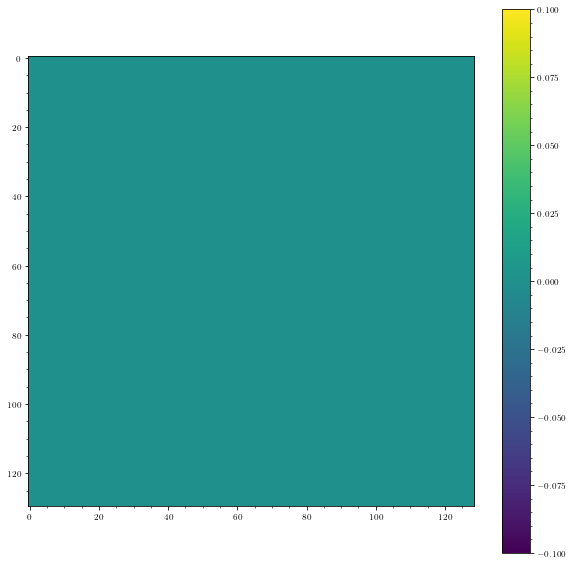

In [658]:
plt.figure(1, facecolor='w', figsize=(10,10))
P.imshow(PEx[0,:,:])
P.colorbar()

1.0000335213642029

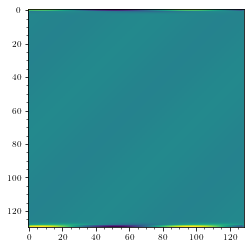

In [659]:
field = By[0, :, :]
plt.figure(1,facecolor='w')
plt.imshow(field)
N.max(N.abs(field))

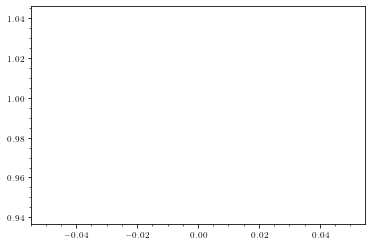

In [660]:
plt.figure(2,facecolor='w')
plt.plot(N.transpose(etot)[0],N.transpose(etot)[1])

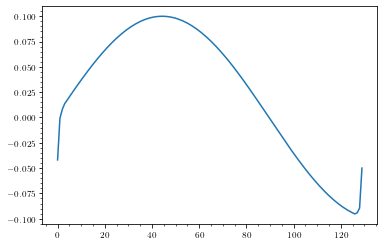

In [661]:
P.plot(N.transpose(Bz[0, :, :])[32])


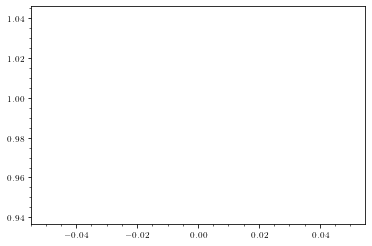

In [662]:
plt.plot(N.transpose(etot)[0],N.transpose(etot)[1])

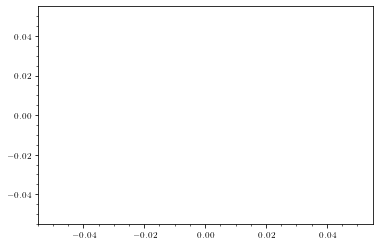

In [663]:
plt.plot(N.transpose(etot)[0][0:-1],N.diff(N.transpose(etot)[1]))

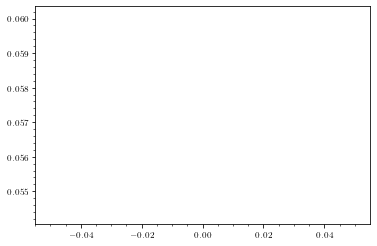

In [664]:
plt.plot(N.transpose(etot)[0],N.transpose(rtot)[1])

In [665]:
p = 0

cutEdotB(0)

Bx_tmp = N.zeros((Nx_half, Ny_int))
By_tmp = N.zeros((Nx_half, Ny_int))
Bz_tmp = N.zeros((Nx_half, Ny_int))
Ex_tmp = N.zeros((Nx_half, Ny_int))
Ey_tmp = N.zeros((Nx_half, Ny_int))
Ez_tmp = N.zeros((Nx_half, Ny_int))
B2_tmp = N.zeros((Nx_half, Ny_int))
DB_tmp = N.zeros((Nx_half, Ny_int))

Bx_tmp[:, :] = inthalf2halfint(Bx0[ :, :])
By_tmp[:, :] = halfint2halfint(By0[ :, :])
Bz_tmp[:, :] = halfhalf2halfint(Bz0[ :, :])
Ex_tmp[:, :] = halfint2halfint(Ex0[ :, :])
Ey_tmp[:, :] = inthalf2halfint(Ey0[ :, :])
Ez_tmp[:, :] = intint2halfint(Ez0[ :, :])

B2_tmp[:, :] = Bx_tmp[:, :]**2 + By_tmp[:, :]**2 + Bz_tmp[:, :]**2
DB_tmp[:, :] = savedivide(Ex_tmp[:, :]*Bx_tmp[:, :] + Ey_tmp[:, :]*By_tmp[:, :] + Ez_tmp[:, :]*Bz_tmp[:, :], B2_tmp[:, :])


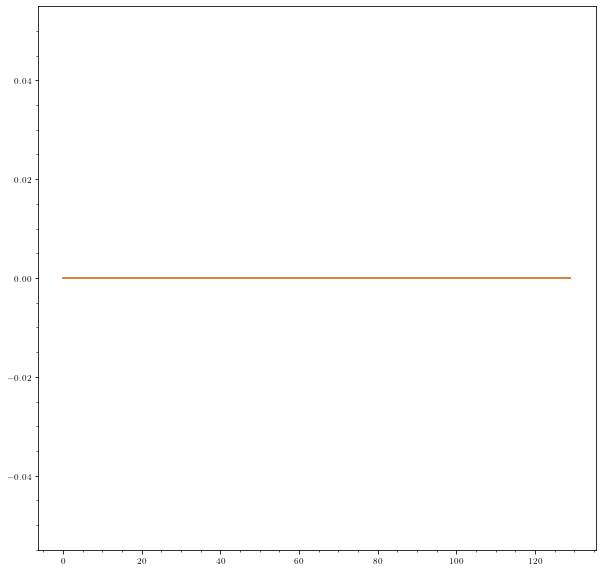

In [666]:
plt.figure(2,facecolor='w',figsize=(10,10))
plt.plot(N.transpose(DB_tmp[:, :])[10])
plt.plot(N.transpose(DB_tmp[:, :])[0])

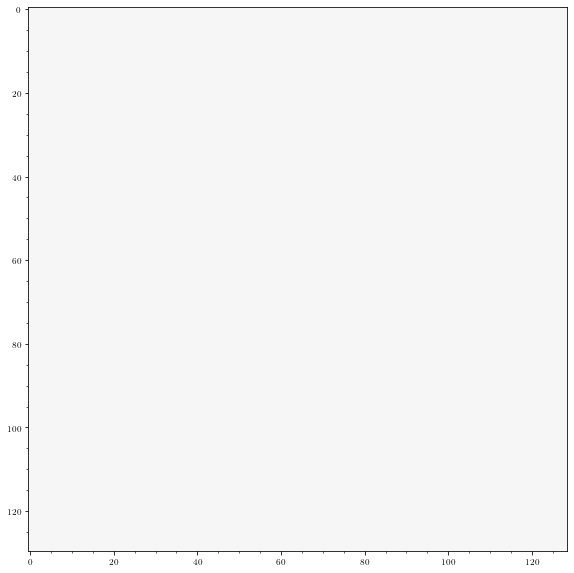

In [667]:
plt.figure(2,facecolor='w',figsize=(10,10))

P.imshow(DB_tmp,vmin=-1e-5,vmax=1e-5,cmap='RdBu_r')

In [668]:
ratio = 1.0

def plot_fields():

    fig = P.figure(1, figsize=(6,6), dpi=100, facecolor='w')
    ax = P.subplot(111)

#     P.pcolormesh(xBz_grid - 0.5, yBz_grid - 0.5, Bz[0, :, :], vmin = -1, vmax = 1, cmap = 'RdBu_r')
#     P.pcolormesh(xBz_grid + 0.5, yBz_grid - 0.5, Bz[1, :, :], vmin = -1, vmax = 1, cmap = 'RdBu_r')
#     P.pcolormesh(xBz_grid - 0.5, yBz_grid + 0.5, Bz[2, :, :], vmin = -1, vmax = 1, cmap = 'RdBu_r')
#     P.pcolormesh(xBz_grid + 0.5, yBz_grid + 0.5, Bz[3, :, :], vmin = -1, vmax = 1, cmap = 'RdBu_r')

#     P.pcolormesh(xEy_grid - 0.5, yEy_grid - 0.5, Bx[0, :, :], vmin = -0.01, vmax = 0.01, cmap = 'RdBu_r')
#     P.pcolormesh(xEy_grid + 0.5, yEy_grid - 0.5, Bx[1, :, :], vmin = -0.01, vmax = 0.01, cmap = 'RdBu_r')
#     P.pcolormesh(xEy_grid - 0.5, yEy_grid + 0.5, Bx[2, :, :], vmin = -0.01, vmax = 0.01, cmap = 'RdBu_r')
#     P.pcolormesh(xEy_grid + 0.5, yEy_grid + 0.5, Bx[3, :, :], vmin = -0.01, vmax = 0.01, cmap = 'RdBu_r')

    P.pcolormesh(xEz_grid - 0.5, yEz_grid - 0.5, rho[0, :, :], vmin = -4.0*amp, vmax = 4.0*amp, cmap = 'RdBu_r')
    P.pcolormesh(xEz_grid + 0.5, yEz_grid - 0.5, rho[1, :, :], vmin = -4.0*amp, vmax = 4.0*amp, cmap = 'RdBu_r')
    P.pcolormesh(xEz_grid - 0.5, yEz_grid + 0.5, rho[2, :, :], vmin = -4.0*amp, vmax = 4.0*amp, cmap = 'RdBu_r')
    P.pcolormesh(xEz_grid + 0.5, yEz_grid + 0.5, rho[3, :, :], vmin = -4.0*amp, vmax = 4.0*amp, cmap = 'RdBu_r')
    
#     P.plot([0, 0],[-1.25, 1.25], color='k')
    
#     P.colorbar()
    
    P.ylim((y_min - 0.5, y_max + 0.5))
    P.xlim((x_min - 0.5, x_max + 0.5))
    ax.set_aspect(1.0/ax.get_data_ratio()*ratio)
    
    plt.axvline(x=0.0, c='black')
    plt.axhline(y=0.0, c='black')
    
    P.show()


IndexError: index 1 is out of bounds for axis 0 with size 1

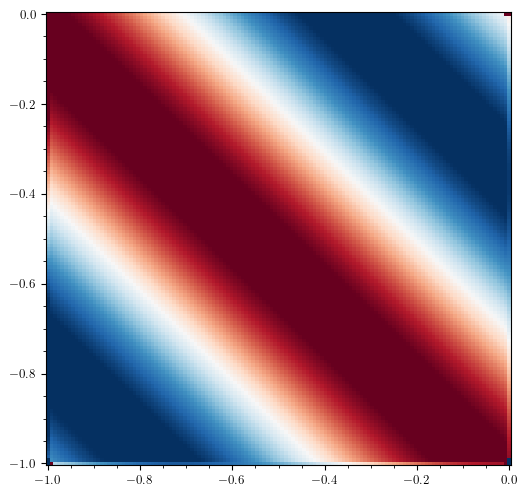

In [669]:
plot_fields()

In [ ]:
ratio = 1.0

def save_fields(iter):

    fig = P.figure(1, figsize=(6,6), dpi=100, facecolor='w')
    ax = P.subplot(111)

#     P.pcolormesh(xBz_grid - 0.5, yBz_grid - 0.5, Bz[0, :, :], vmin = -1, vmax = 1, cmap = 'RdBu_r')
#     P.pcolormesh(xBz_grid + 0.5, yBz_grid - 0.5, Bz[1, :, :], vmin = -1, vmax = 1, cmap = 'RdBu_r')
#     P.pcolormesh(xBz_grid - 0.5, yBz_grid + 0.5, Bz[2, :, :], vmin = -1, vmax = 1, cmap = 'RdBu_r')
#     P.pcolormesh(xBz_grid + 0.5, yBz_grid + 0.5, Bz[3, :, :], vmin = -1, vmax = 1, cmap = 'RdBu_r')

    P.pcolormesh(xBz_grid - 0.5, yBz_grid - 0.5, Bz[0, :, :], vmin = -amp, vmax = amp, cmap = 'RdBu_r')
    P.pcolormesh(xBz_grid + 0.5, yBz_grid - 0.5, Bz[1, :, :], vmin = -amp, vmax = amp, cmap = 'RdBu_r')
    P.pcolormesh(xBz_grid - 0.5, yBz_grid + 0.5, Bz[2, :, :], vmin = -amp, vmax = amp, cmap = 'RdBu_r')
    P.pcolormesh(xBz_grid + 0.5, yBz_grid + 0.5, Bz[3, :, :], vmin = -amp, vmax = amp, cmap = 'RdBu_r')

#     P.pcolormesh(xEy_grid - 0.5, yEy_grid - 0.5, Bx[0, :, :], vmin = -0.01, vmax = 0.01, cmap = 'RdBu_r')
#     P.pcolormesh(xEy_grid + 0.5, yEy_grid - 0.5, Bx[1, :, :], vmin = -0.01, vmax = 0.01, cmap = 'RdBu_r')
#     P.pcolormesh(xEy_grid - 0.5, yEy_grid + 0.5, Bx[2, :, :], vmin = -0.01, vmax = 0.01, cmap = 'RdBu_r')
#     P.pcolormesh(xEy_grid + 0.5, yEy_grid + 0.5, Bx[3, :, :], vmin = -0.01, vmax = 0.01, cmap = 'RdBu_r')

#     P.pcolormesh(xEx_grid - 0.5, yEx_grid - 0.5, By[0, :, :], vmin = -amp, vmax = amp, cmap = 'RdBu_r')
#     P.pcolormesh(xEx_grid + 0.5, yEx_grid - 0.5, By[1, :, :], vmin = -amp, vmax = amp, cmap = 'RdBu_r')
#     P.pcolormesh(xEx_grid - 0.5, yEx_grid + 0.5, By[2, :, :], vmin = -amp, vmax = amp, cmap = 'RdBu_r')
#     P.pcolormesh(xEx_grid + 0.5, yEx_grid + 0.5, By[3, :, :], vmin = -amp, vmax = amp, cmap = 'RdBu_r')
    
#     P.plot([0, 0],[-1.25, 1.25], color='k')
    
#     P.colorbar()
    
    P.ylim((y_min - 0.5, y_max + 0.5))
    P.xlim((x_min - 0.5, x_max + 0.5))
    ax.set_aspect(1.0/ax.get_data_ratio()*ratio)
    
    plt.axvline(x=0.0, c='black')
    plt.axhline(y=0.0, c='black')
    
    plt.savefig('/home/mahlmann/Pictures/CUBEDAW-'+str(iter)+'.jpg', bbox_inches='tight', dpi=200)
    plt.close()
    

In [ ]:
ratio = 1.0

def save_charge(iter):

    fig = P.figure(1, figsize=(6,6), dpi=100, facecolor='w')
    ax = P.subplot(111)

#     P.pcolormesh(xBz_grid - 0.5, yBz_grid - 0.5, Bz[0, :, :], vmin = -1, vmax = 1, cmap = 'RdBu_r')
#     P.pcolormesh(xBz_grid + 0.5, yBz_grid - 0.5, Bz[1, :, :], vmin = -1, vmax = 1, cmap = 'RdBu_r')
#     P.pcolormesh(xBz_grid - 0.5, yBz_grid + 0.5, Bz[2, :, :], vmin = -1, vmax = 1, cmap = 'RdBu_r')
#     P.pcolormesh(xBz_grid + 0.5, yBz_grid + 0.5, Bz[3, :, :], vmin = -1, vmax = 1, cmap = 'RdBu_r')

#     P.pcolormesh(xEy_grid - 0.5, yEy_grid - 0.5, Bx[0, :, :], vmin = -0.01, vmax = 0.01, cmap = 'RdBu_r')
#     P.pcolormesh(xEy_grid + 0.5, yEy_grid - 0.5, Bx[1, :, :], vmin = -0.01, vmax = 0.01, cmap = 'RdBu_r')
#     P.pcolormesh(xEy_grid - 0.5, yEy_grid + 0.5, Bx[2, :, :], vmin = -0.01, vmax = 0.01, cmap = 'RdBu_r')
#     P.pcolormesh(xEy_grid + 0.5, yEy_grid + 0.5, Bx[3, :, :], vmin = -0.01, vmax = 0.01, cmap = 'RdBu_r')

    P.pcolormesh(xEz_grid - 0.5, yEz_grid - 0.5, rho[0, :, :], vmin = -4.0*amp, vmax = 4.0*amp, cmap = 'RdBu_r')
    P.pcolormesh(xEz_grid + 0.5, yEz_grid - 0.5, rho[1, :, :], vmin = -4.0*amp, vmax = 4.0*amp, cmap = 'RdBu_r')
    P.pcolormesh(xEz_grid - 0.5, yEz_grid + 0.5, rho[2, :, :], vmin = -4.0*amp, vmax = 4.0*amp, cmap = 'RdBu_r')
    P.pcolormesh(xEz_grid + 0.5, yEz_grid + 0.5, rho[3, :, :], vmin = -4.0*amp, vmax = 4.0*amp, cmap = 'RdBu_r')
    
#     P.plot([0, 0],[-1.25, 1.25], color='k')
    
#     P.colorbar()
    
    P.ylim((y_min - 0.5, y_max + 0.5))
    P.xlim((x_min - 0.5, x_max + 0.5))
    ax.set_aspect(1.0/ax.get_data_ratio()*ratio)
    
    plt.axvline(x=0.0, c='black')
    plt.axhline(y=0.0, c='black')
    
    plt.savefig('/home/mahlmann/Pictures/CUBEDAW-'+str(iter)+'.jpg', bbox_inches='tight', dpi=200)
    plt.close()
    

In [ ]:
energy48 = etot

In [ ]:
energy64 = etot

In [ ]:
h5f = h5py.File('/home/mahlmann/CUBED/convergence/enrgf4_64.h5', 'w')
h5f.create_dataset('T', data=N.transpose(energy64)[0])
h5f.create_dataset('E', data=N.transpose(energy64)[1])
h5f.close()

In [ ]:
#     for p in range(n_patches):
        
#         BxRKQ0[p, :, :] = Bx[p, :, :]
#         ByRKQ0[p, :, :] = By[p, :, :]
#         BzRKQ0[p, :, :] = Bz[p, :, :]
#         ExRKQ0[p, :, :] = Ex[p, :, :]
#         EyRKQ0[p, :, :] = Ey[p, :, :]
#         EzRKQ0[p, :, :] = Ez[p, :, :]
        
#         compute_diff_B(p)
#         compute_diff_E(p)
#         getJ(p)

#     PBx = N.zeros((n_patches, Nx_int, Ny_half))
#     PBy = N.zeros((n_patches, Ny_half, Ny_int))
#     PBz = N.zeros((n_patches, Nx_half, Ny_half))
#     PEx = N.zeros((n_patches, Nx_half, Ny_int))
#     PEy = N.zeros((n_patches, Nx_int, Ny_half))
#     PEz = N.zeros((n_patches, Nx_int, Ny_int))
#     compute_penalties()
    
#     for p in range(n_patches):
    
#         BxRKQ1[p, :, :] = BxRKQ0[p, :, :] + 0.5 * dt * (dEydz[p, :, :] - dEzdy[p, :, :]) + 0.5 * dt * PBx[p, :, :]
#         ByRKQ1[p, :, :] = ByRKQ0[p, :, :] + 0.5 * dt * (dEzdx[p, :, :] - dExdz[p, :, :]) + 0.5 * dt * PBy[p, :, :]
#         BzRKQ1[p, :, :] = BzRKQ0[p, :, :] + 0.5 * dt * (dExdy[p, :, :] - dEydx[p, :, :]) + 0.5 * dt * PBz[p, :, :]
#         ExRKQ1[p, :, :] = ExRKQ0[p, :, :] + 0.5 * dt * (dBzdy[p, :, :] - dBydz[p, :, :]) + 0.5 * dt * PEx[p, :, :] - 0.5 * dt * Jx[p, :, :]
#         EyRKQ1[p, :, :] = EyRKQ0[p, :, :] + 0.5 * dt * (dBxdz[p, :, :] - dBzdx[p, :, :]) + 0.5 * dt * PEy[p, :, :] - 0.5 * dt * Jy[p, :, :]
#         EzRKQ1[p, :, :] = EzRKQ0[p, :, :] + 0.5 * dt * (dBydx[p, :, :] - dBxdy[p, :, :]) + 0.5 * dt * PEz[p, :, :] - 0.5 * dt * Jz[p, :, :]
        
#         Bx[p, :, :] = BxRKQ1[p, :, :]
#         By[p, :, :] = ByRKQ1[p, :, :]
#         Bz[p, :, :] = BzRKQ1[p, :, :]
#         Ex[p, :, :] = ExRKQ1[p, :, :]
#         Ey[p, :, :] = EyRKQ1[p, :, :]
#         Ez[p, :, :] = EzRKQ1[p, :, :]
        
#         cutEdotB(p)
#         cutEsqBsq(p)
    
#         compute_diff_B(p)
#         compute_diff_E(p)
#         getJ(p)

#     PBx = N.zeros((n_patches, Nx_int, Ny_half))
#     PBy = N.zeros((n_patches, Ny_half, Ny_int))
#     PBz = N.zeros((n_patches, Nx_half, Ny_half))
#     PEx = N.zeros((n_patches, Nx_half, Ny_int))
#     PEy = N.zeros((n_patches, Nx_int, Ny_half))
#     PEz = N.zeros((n_patches, Nx_int, Ny_int))
#     compute_penalties()
    
#     for p in range(n_patches):
        
#         BxRKQ2[p, :, :] = BxRKQ0[p, :, :] + 0.5 * dt * (dEydz[p, :, :] - dEzdy[p, :, :]) + 0.5 * dt * PBx[p, :, :]
#         ByRKQ2[p, :, :] = ByRKQ0[p, :, :] + 0.5 * dt * (dEzdx[p, :, :] - dExdz[p, :, :]) + 0.5 * dt * PBy[p, :, :]
#         BzRKQ2[p, :, :] = BzRKQ0[p, :, :] + 0.5 * dt * (dExdy[p, :, :] - dEydx[p, :, :]) + 0.5 * dt * PBz[p, :, :]
#         ExRKQ2[p, :, :] = ExRKQ0[p, :, :] + 0.5 * dt * (dBzdy[p, :, :] - dBydz[p, :, :]) + 0.5 * dt * PEx[p, :, :] - 0.5 * dt * Jx[p, :, :]
#         EyRKQ2[p, :, :] = EyRKQ0[p, :, :] + 0.5 * dt * (dBxdz[p, :, :] - dBzdx[p, :, :]) + 0.5 * dt * PEy[p, :, :] - 0.5 * dt * Jy[p, :, :]
#         EzRKQ2[p, :, :] = EzRKQ0[p, :, :] + 0.5 * dt * (dBydx[p, :, :] - dBxdy[p, :, :]) + 0.5 * dt * PEz[p, :, :] - 0.5 * dt * Jz[p, :, :]
        
#         Bx[p, :, :] = BxRKQ2[p, :, :]
#         By[p, :, :] = ByRKQ2[p, :, :]
#         Bz[p, :, :] = BzRKQ2[p, :, :]
#         Ex[p, :, :] = ExRKQ2[p, :, :]
#         Ey[p, :, :] = EyRKQ2[p, :, :]
#         Ez[p, :, :] = EzRKQ2[p, :, :]
    
#         cutEdotB(p)
#         cutEsqBsq(p)
    
#         compute_diff_B(p)
#         compute_diff_E(p)
#         getJ(p)
        
#     PBx = N.zeros((n_patches, Nx_int, Ny_half))
#     PBy = N.zeros((n_patches, Ny_half, Ny_int))
#     PBz = N.zeros((n_patches, Nx_half, Ny_half))
#     PEx = N.zeros((n_patches, Nx_half, Ny_int))
#     PEy = N.zeros((n_patches, Nx_int, Ny_half))
#     PEz = N.zeros((n_patches, Nx_int, Ny_int))
#     compute_penalties()
    
#     for p in range(n_patches):
    
#         BxRKQ3[p, :, :] = BxRKQ0[p, :, :] + 1.0 * dt * (dEydz[p, :, :] - dEzdy[p, :, :]) + 1.0 * dt * PBx[p, :, :]
#         ByRKQ3[p, :, :] = ByRKQ0[p, :, :] + 1.0 * dt * (dEzdx[p, :, :] - dExdz[p, :, :]) + 1.0 * dt * PBy[p, :, :]
#         BzRKQ3[p, :, :] = BzRKQ0[p, :, :] + 1.0 * dt * (dExdy[p, :, :] - dEydx[p, :, :]) + 1.0 * dt * PBz[p, :, :]
#         ExRKQ3[p, :, :] = ExRKQ0[p, :, :] + 1.0 * dt * (dBzdy[p, :, :] - dBydz[p, :, :]) + 1.0 * dt * PEx[p, :, :] - 1.0 * dt * Jx[p, :, :]
#         EyRKQ3[p, :, :] = EyRKQ0[p, :, :] + 1.0 * dt * (dBxdz[p, :, :] - dBzdx[p, :, :]) + 1.0 * dt * PEy[p, :, :] - 1.0 * dt * Jy[p, :, :]
#         EzRKQ3[p, :, :] = EzRKQ0[p, :, :] + 1.0 * dt * (dBydx[p, :, :] - dBxdy[p, :, :]) + 1.0 * dt * PEz[p, :, :] - 1.0 * dt * Jz[p, :, :]
        
#         Bx[p, :, :] = BxRKQ3[p, :, :]
#         By[p, :, :] = ByRKQ3[p, :, :]
#         Bz[p, :, :] = BzRKQ3[p, :, :]
#         Ex[p, :, :] = ExRKQ3[p, :, :]
#         Ey[p, :, :] = EyRKQ3[p, :, :]
#         Ez[p, :, :] = EzRKQ3[p, :, :]
    
#         cutEdotB(p)
#         cutEsqBsq(p)
    
#         compute_diff_B(p)
#         compute_diff_E(p)    
#         getJ(p)

#     PBx = N.zeros((n_patches, Nx_int, Ny_half))
#     PBy = N.zeros((n_patches, Ny_half, Ny_int))
#     PBz = N.zeros((n_patches, Nx_half, Ny_half))
#     PEx = N.zeros((n_patches, Nx_half, Ny_int))
#     PEy = N.zeros((n_patches, Nx_int, Ny_half))
#     PEz = N.zeros((n_patches, Nx_int, Ny_int))
#     compute_penalties()
    
#     for p in range(n_patches):
    
#         Bx[p, :, :] = 1.0/6.0 * (- 2.0 * BxRKQ0[p, :, :] + 2.0 * BxRKQ1[p, :, :] + 4.0 * BxRKQ2[p, :, :] + 2.0 * BxRKQ3[p, :, :] + 1.0 * dt * (dEydz[p, :, :] - dEzdy[p, :, :]) + 1.0 * dt * PBx[p, :, :])
#         By[p, :, :] = 1.0/6.0 * (- 2.0 * ByRKQ0[p, :, :] + 2.0 * ByRKQ1[p, :, :] + 4.0 * ByRKQ2[p, :, :] + 2.0 * ByRKQ3[p, :, :] + 1.0 * dt * (dEzdx[p, :, :] - dExdz[p, :, :]) + 1.0 * dt * PBy[p, :, :])
#         Bz[p, :, :] = 1.0/6.0 * (- 2.0 * BzRKQ0[p, :, :] + 2.0 * BzRKQ1[p, :, :] + 4.0 * BzRKQ2[p, :, :] + 2.0 * BzRKQ3[p, :, :] + 1.0 * dt * (dExdy[p, :, :] - dEydx[p, :, :]) + 1.0 * dt * PBz[p, :, :])
#         Ex[p, :, :] = 1.0/6.0 * (- 2.0 * ExRKQ0[p, :, :] + 2.0 * ExRKQ1[p, :, :] + 4.0 * ExRKQ2[p, :, :] + 2.0 * ExRKQ3[p, :, :] + 1.0 * dt * (dBzdy[p, :, :] - dBydz[p, :, :]) + 1.0 * dt * PEx[p, :, :] - 1.0 * dt * Jx[p, :, :])
#         Ey[p, :, :] = 1.0/6.0 * (- 2.0 * EyRKQ0[p, :, :] + 2.0 * EyRKQ1[p, :, :] + 4.0 * EyRKQ2[p, :, :] + 2.0 * EyRKQ3[p, :, :] + 1.0 * dt * (dBxdz[p, :, :] - dBzdx[p, :, :]) + 1.0 * dt * PEy[p, :, :] - 1.0 * dt * Jy[p, :, :])
#         Ez[p, :, :] = 1.0/6.0 * (- 2.0 * EzRKQ0[p, :, :] + 2.0 * EzRKQ1[p, :, :] + 4.0 * EzRKQ2[p, :, :] + 2.0 * EzRKQ3[p, :, :] + 1.0 * dt * (dBydx[p, :, :] - dBxdy[p, :, :]) + 1.0 * dt * PEz[p, :, :] - 1.0 * dt * Jz[p, :, :])

#         cutEdotB(p)
#         cutEsqBsq(p)
        
        

In [ ]:
Nt = 500 #int(1.0*12500) # Number of iterations
time = dt * N.arange(Nt)
energy = N.zeros((n_patches, Nt))

for it in tqdm(range(Nt), "Progression"):
    
    for p in range(n_patches):
        
        BxRKQ0[p, :, :] = Bx[p, :, :]
        ByRKQ0[p, :, :] = By[p, :, :]
        BzRKQ0[p, :, :] = Bz[p, :, :]
        ExRKQ0[p, :, :] = Ex[p, :, :]
        EyRKQ0[p, :, :] = Ey[p, :, :]
        EzRKQ0[p, :, :] = Ez[p, :, :]
        
        compute_diff_B(p)
        compute_diff_E(p)
        
    PBx = N.zeros((n_patches, Nx_int, Ny_half))
    PBy = N.zeros((n_patches, Ny_half, Ny_int))
    PBz = N.zeros((n_patches, Nx_half, Ny_half))
    PEx = N.zeros((n_patches, Nx_half, Ny_int))
    PEy = N.zeros((n_patches, Nx_int, Ny_half))
    PEz = N.zeros((n_patches, Nx_int, Ny_int))
    compute_penalties()
   
    Jx = N.zeros((n_patches, Nx_half, Ny_int))
    Jy = N.zeros((n_patches, Nx_int, Ny_half))
    Jz = N.zeros((n_patches, Nx_int, Ny_int))
    rho = N.zeros((n_patches, Nx_int, Ny_int))

    for p in range(n_patches):
    
        getrho(p)
        getJ(p)
    
        BxRKQ1[p, :, :] = BxRKQ0[p, :, :] + 1.0 * dt * (dEydz[p, :, :] - dEzdy[p, :, :]) + 1.0 * dt * PBx[p, :, :]
        ByRKQ1[p, :, :] = ByRKQ0[p, :, :] + 1.0 * dt * (dEzdx[p, :, :] - dExdz[p, :, :]) + 1.0 * dt * PBy[p, :, :]
        BzRKQ1[p, :, :] = BzRKQ0[p, :, :] + 1.0 * dt * (dExdy[p, :, :] - dEydx[p, :, :]) + 1.0 * dt * PBz[p, :, :]
        ExRKQ1[p, :, :] = ExRKQ0[p, :, :] + 1.0 * dt * (dBzdy[p, :, :] - dBydz[p, :, :]) + 1.0 * dt * PEx[p, :, :] - 1.0 * dt * Jx[p, :, :]
        EyRKQ1[p, :, :] = EyRKQ0[p, :, :] + 1.0 * dt * (dBxdz[p, :, :] - dBzdx[p, :, :]) + 1.0 * dt * PEy[p, :, :] - 1.0 * dt * Jy[p, :, :]
        EzRKQ1[p, :, :] = EzRKQ0[p, :, :] + 1.0 * dt * (dBydx[p, :, :] - dBxdy[p, :, :]) + 1.0 * dt * PEz[p, :, :] - 1.0 * dt * Jz[p, :, :]
        
        Bx[p, :, :] = BxRKQ1[p, :, :]
        By[p, :, :] = ByRKQ1[p, :, :]
        Bz[p, :, :] = BzRKQ1[p, :, :]
        Ex[p, :, :] = ExRKQ1[p, :, :]
        Ey[p, :, :] = EyRKQ1[p, :, :]
        Ez[p, :, :] = EzRKQ1[p, :, :]
        
#         cutEdotB(p)
        cutEsqBsq(p)
        
        BxRKQ1[p, :, :] = Bx[p, :, :]
        ByRKQ1[p, :, :] = By[p, :, :]
        BzRKQ1[p, :, :] = Bz[p, :, :]
        ExRKQ1[p, :, :] = Ex[p, :, :]
        EyRKQ1[p, :, :] = Ey[p, :, :]
        EzRKQ1[p, :, :] = Ez[p, :, :]
    
        compute_diff_B(p)
        compute_diff_E(p)

    PBx = N.zeros((n_patches, Nx_int, Ny_half))
    PBy = N.zeros((n_patches, Ny_half, Ny_int))
    PBz = N.zeros((n_patches, Nx_half, Ny_half))
    PEx = N.zeros((n_patches, Nx_half, Ny_int))
    PEy = N.zeros((n_patches, Nx_int, Ny_half))
    PEz = N.zeros((n_patches, Nx_int, Ny_int))
    compute_penalties()
    
    Jx = N.zeros((n_patches, Nx_half, Ny_int))
    Jy = N.zeros((n_patches, Nx_int, Ny_half))
    Jz = N.zeros((n_patches, Nx_int, Ny_int))
    rho = N.zeros((n_patches, Nx_int, Ny_int))
    
    for p in range(n_patches):
        
        getrho(p)
        getJ(p)
        
        BxRKQ2[p, :, :] = 1.0/4.0 * (3.0 * BxRKQ0[p, :, :] + 1.0 * BxRKQ1[p, :, :] + 1.0 * dt * (dEydz[p, :, :] - dEzdy[p, :, :]) + 1.0 * dt * PBx[p, :, :])
        ByRKQ2[p, :, :] = 1.0/4.0 * (3.0 * ByRKQ0[p, :, :] + 1.0 * ByRKQ1[p, :, :] + 1.0 * dt * (dEzdx[p, :, :] - dExdz[p, :, :]) + 1.0 * dt * PBy[p, :, :])
        BzRKQ2[p, :, :] = 1.0/4.0 * (3.0 * BzRKQ0[p, :, :] + 1.0 * BzRKQ1[p, :, :] + 1.0 * dt * (dExdy[p, :, :] - dEydx[p, :, :]) + 1.0 * dt * PBz[p, :, :])
        ExRKQ2[p, :, :] = 1.0/4.0 * (3.0 * ExRKQ0[p, :, :] + 1.0 * ExRKQ1[p, :, :] + 1.0 * dt * (dBzdy[p, :, :] - dBydz[p, :, :]) + 1.0 * dt * PEx[p, :, :] - 1.0 * dt * Jx[p, :, :])
        EyRKQ2[p, :, :] = 1.0/4.0 * (3.0 * EyRKQ0[p, :, :] + 1.0 * EyRKQ1[p, :, :] + 1.0 * dt * (dBxdz[p, :, :] - dBzdx[p, :, :]) + 1.0 * dt * PEy[p, :, :] - 1.0 * dt * Jy[p, :, :])
        EzRKQ2[p, :, :] = 1.0/4.0 * (3.0 * EzRKQ0[p, :, :] + 1.0 * EzRKQ1[p, :, :] + 1.0 * dt * (dBydx[p, :, :] - dBxdy[p, :, :]) + 1.0 * dt * PEz[p, :, :] - 1.0 * dt * Jz[p, :, :])
        
        Bx[p, :, :] = BxRKQ2[p, :, :]
        By[p, :, :] = ByRKQ2[p, :, :]
        Bz[p, :, :] = BzRKQ2[p, :, :]
        Ex[p, :, :] = ExRKQ2[p, :, :]
        Ey[p, :, :] = EyRKQ2[p, :, :]
        Ez[p, :, :] = EzRKQ2[p, :, :]
    
#         cutEdotB(p)
        cutEsqBsq(p)
        
        BxRKQ2[p, :, :] = Bx[p, :, :]
        ByRKQ2[p, :, :] = By[p, :, :]
        BzRKQ2[p, :, :] = Bz[p, :, :]
        ExRKQ2[p, :, :] = Ex[p, :, :]
        EyRKQ2[p, :, :] = Ey[p, :, :]
        EzRKQ2[p, :, :] = Ez[p, :, :]
    
        compute_diff_B(p)
        compute_diff_E(p)
        
    PBx = N.zeros((n_patches, Nx_int, Ny_half))
    PBy = N.zeros((n_patches, Ny_half, Ny_int))
    PBz = N.zeros((n_patches, Nx_half, Ny_half))
    PEx = N.zeros((n_patches, Nx_half, Ny_int))
    PEy = N.zeros((n_patches, Nx_int, Ny_half))
    PEz = N.zeros((n_patches, Nx_int, Ny_int))
    compute_penalties()
    
    Jx = N.zeros((n_patches, Nx_half, Ny_int))
    Jy = N.zeros((n_patches, Nx_int, Ny_half))
    Jz = N.zeros((n_patches, Nx_int, Ny_int))
    rho = N.zeros((n_patches, Nx_int, Ny_int))
    
    for p in range(n_patches):
    
        getrho(p)
        getJ(p)
    
        Bx[p, :, :] = 1.0/3.0 * (BxRKQ0[p, :, :] + 2.0 * BxRKQ2[p, :, :] + 2.0 * dt * (dEydz[p, :, :] - dEzdy[p, :, :]) + 2.0 * dt * PBx[p, :, :])
        By[p, :, :] = 1.0/3.0 * (ByRKQ0[p, :, :] + 2.0 * ByRKQ2[p, :, :] + 2.0 * dt * (dEzdx[p, :, :] - dExdz[p, :, :]) + 2.0 * dt * PBy[p, :, :])
        Bz[p, :, :] = 1.0/3.0 * (BzRKQ0[p, :, :] + 2.0 * BzRKQ2[p, :, :] + 2.0 * dt * (dExdy[p, :, :] - dEydx[p, :, :]) + 2.0 * dt * PBz[p, :, :])
        Ex[p, :, :] = 1.0/3.0 * (ExRKQ0[p, :, :] + 2.0 * ExRKQ2[p, :, :] + 2.0 * dt * (dBzdy[p, :, :] - dBydz[p, :, :]) + 2.0 * dt * PEx[p, :, :] - 2.0 * dt * Jx[p, :, :])
        Ey[p, :, :] = 1.0/3.0 * (EyRKQ0[p, :, :] + 2.0 * EyRKQ2[p, :, :] + 2.0 * dt * (dBxdz[p, :, :] - dBzdx[p, :, :]) + 2.0 * dt * PEy[p, :, :] - 2.0 * dt * Jy[p, :, :])
        Ez[p, :, :] = 1.0/3.0 * (EzRKQ0[p, :, :] + 2.0 * EzRKQ2[p, :, :] + 2.0 * dt * (dBydx[p, :, :] - dBxdy[p, :, :]) + 2.0 * dt * PEz[p, :, :] - 2.0 * dt * Jz[p, :, :])
    
        cutEdotB(p)
        cutEsqBsq(p)


    if (it%10 == 0):
        etot.append([it*dt,compute_energy()])
        rtot.append([it*dt,compute_charge()])
#         save_fields(it)
#         save_charge(it)
